# Librerías

In [1]:
!pip install optuna

  Using cached optuna-3.1.1-py3-none-any.whl (365 kB)
  Using cached colorlog-6.7.0-py2.py3-none-any.whl (11 kB)
  Using cached cmaes-0.9.1-py3-none-any.whl (21 kB)
  Using cached alembic-1.11.1-py3-none-any.whl (224 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Using cached Mako-1.2.4-py3-none-any.whl (78 kB)


In [2]:
import sys
import os
sys.path.append(".")
import re
import pandas as pd
import numpy as np
import pandasql as ps
from datetime import timedelta
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
def thousands_formatter_func(x, pos):
    return f'{int(x / 1e3)}K'
thousand_formatter = FuncFormatter(thousands_formatter_func)
def decimal_percentage_formatter_func(x, pos):
    return f'{int(x * 100)}%'
decimal_percentage_formatter = FuncFormatter(decimal_percentage_formatter_func)
def percentage_formatter_func(x, pos):
    return f'{int(x)}%'
percentage_formatter = FuncFormatter(percentage_formatter_func)

# Lectura archivos

In [3]:
df_bombs = pd.read_csv('data/processed_csv/df_bombs.csv', delimiter=',', encoding='latin-1', index_col=0)
df_of = pd.read_csv('data/processed_csv/df_of.csv', delimiter=',', encoding='latin-1')
df_operators = pd.read_csv('data/processed_csv/df_operators.csv', delimiter=',', encoding='latin-1')
df_operators_participation = pd.read_csv('data/processed_csv/df_operators_participation.csv', delimiter=',', encoding='latin-1')

df_bombs['start_date'] = pd.to_datetime(df_bombs['start_date'], format='%Y-%m-%d %H:%M:%S.%f')
df_bombs['end_date'] = pd.to_datetime(df_bombs['end_date'], format='%Y-%m-%d %H:%M:%S.%f')
df_of['start_date'] = pd.to_datetime(df_of['start_date'], format='%Y-%m-%d %H:%M:%S.%f')
df_of['end_date'] = pd.to_datetime(df_of['end_date'], format='%Y-%m-%d %H:%M:%S.%f')



In [4]:
df_of.line = df_of.line.replace({"LÃ\x8dNEA 2": "LINEA_2", "LINEA_4": "LINEA_4", "LÃ\x8dNEA 1": "LINEA_1", "LINEA_6": "LINEA_6",
                    "LINEA 3": "LINEA_3", "LÃ\x8dNEA KIVU": "LINEA_KIVU", "PREFILTRO L-1": "PREFILTRO_L-1", "PREFILTRO L-6": "PREFILTRO_L-6",
                        "LINEA 7": "LINEA_7", "LINEA 8 IML": "LINEA_8_IML"})
df_operators_participation.line = df_operators_participation.line.replace({"LÃ\x8dNEA 2": "LINEA_2", "LINEA_4": "LINEA_4", "LÃ\x8dNEA 1": "LINEA_1", "LINEA_6": "LINEA_6",
                    "LINEA 3": "LINEA_3", "LÃ\x8dNEA KIVU": "LINEA_KIVU", "PREFILTRO L-1": "PREFILTRO_L-1", "PREFILTRO L-6": "PREFILTRO_L-6",
                        "LINEA 7": "LINEA_7", "LINEA 8 IML": "LINEA_8_IML"})

df_of.line.unique()

array(['LINEA_2', 'LINEA 4', 'LINEA 6', 'LINEA_1', 'LINEA_3',
       'LINEA_KIVU', 'PREFILTRO_L-1', 'PREFILTRO_L-6', 'LINEA_7',
       'LINEA_8_IML'], dtype=object)

In [5]:
def remove_special_chars(text):
    # Agrega los caracteres especiales que deseas eliminar, incluyendo los tildes
    special_chars = r"[^\w\sáéíóúÁÉÍÓÚñÑÃ]"
    text_without_special_chars = re.sub(special_chars, '', text)
    # Agrega aquí cualquier otro reemplazo adicional que desees realizar
    return text_without_special_chars

In [6]:
df_of['line'].apply(remove_special_chars)

0       LINEA_2
1       LINEA 4
2       LINEA 6
3       LINEA_1
4       LINEA 6
         ...   
5090    LINEA_2
5091    LINEA_2
5092    LINEA_2
5093    LINEA_7
5094    LINEA_7
Name: line, Length: 5095, dtype: object

In [7]:
df_of["weekday"] = df_of["start_date"].dt.weekday.astype("category")
df_of["turn"] = df_of["start_date"].apply(lambda x: 'AM' if x.hour < 14 else 'PM')
df_of["month"] = df_of["start_date"].dt.month.astype("category")
df_of["year"] = df_of["start_date"].dt.year.astype("category")


In [8]:
df_of.head()

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round,time_diff_hours_calculated,performance_category,weekday,turn,month,year
0,274185,HPS050M,LINEA_2,1.0,0.0,0.0,0.0,0.0,2020-02-28 07:47:47.760,2021-02-18 08:44:11.897,13189,13.35,13189.211,219.820183,590.426267,"['9105', '918', '8177', '8164', '8230', '9104'...",10,11,44.226687,44.0,0.000000,0.0,3.663670,0% - 10%,4,AM,2,2020
1,5029646,25461,LINEA 4,1.0,17.0,0.0,0.0,0.0,2020-05-26 10:42:49.543,2021-04-07 05:41:01.177,120,8.80,118.318,1.971967,3.112383,"['9120', '8866', '5020', '8860', '8822']",4,5,0.353680,0.0,0.000000,NaN,0.032866,0% - 10%,1,AM,5,2020
2,5070828,11509,LINEA 6,12.0,0.0,0.0,0.0,0.0,2020-04-17 05:47:54.977,2022-08-10 06:10:35.247,32671,17.40,32671.480,544.524667,594.821567,"['9436', '9142', '5033']",8,3,34.185148,34.0,0.000000,0.0,9.075411,0% - 10%,4,AM,4,2020
3,5157110,01226-0890,LINEA_1,2.0,2.0,0.0,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,['5025'],8,1,2.458296,2.0,0.813572,1.0,3.506349,80% - 90%,0,AM,1,2020
4,5158184,11509INT,LINEA 6,12.0,12.0,0.0,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,"['504', '1007', '287', '8945']",2,4,11.835761,12.0,1.013877,1.0,0.961656,100% - 110%,5,AM,1,2020


# Distribución Performance

In [9]:
df_of.head()

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round,time_diff_hours_calculated,performance_category,weekday,turn,month,year
0,274185,HPS050M,LINEA_2,1.0,0.0,0.0,0.0,0.0,2020-02-28 07:47:47.760,2021-02-18 08:44:11.897,13189,13.35,13189.211,219.820183,590.426267,"['9105', '918', '8177', '8164', '8230', '9104'...",10,11,44.226687,44.0,0.000000,0.0,3.663670,0% - 10%,4,AM,2,2020
1,5029646,25461,LINEA 4,1.0,17.0,0.0,0.0,0.0,2020-05-26 10:42:49.543,2021-04-07 05:41:01.177,120,8.80,118.318,1.971967,3.112383,"['9120', '8866', '5020', '8860', '8822']",4,5,0.353680,0.0,0.000000,NaN,0.032866,0% - 10%,1,AM,5,2020
2,5070828,11509,LINEA 6,12.0,0.0,0.0,0.0,0.0,2020-04-17 05:47:54.977,2022-08-10 06:10:35.247,32671,17.40,32671.480,544.524667,594.821567,"['9436', '9142', '5033']",8,3,34.185148,34.0,0.000000,0.0,9.075411,0% - 10%,4,AM,4,2020
3,5157110,01226-0890,LINEA_1,2.0,2.0,0.0,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,['5025'],8,1,2.458296,2.0,0.813572,1.0,3.506349,80% - 90%,0,AM,1,2020
4,5158184,11509INT,LINEA 6,12.0,12.0,0.0,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,"['504', '1007', '287', '8945']",2,4,11.835761,12.0,1.013877,1.0,0.961656,100% - 110%,5,AM,1,2020


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


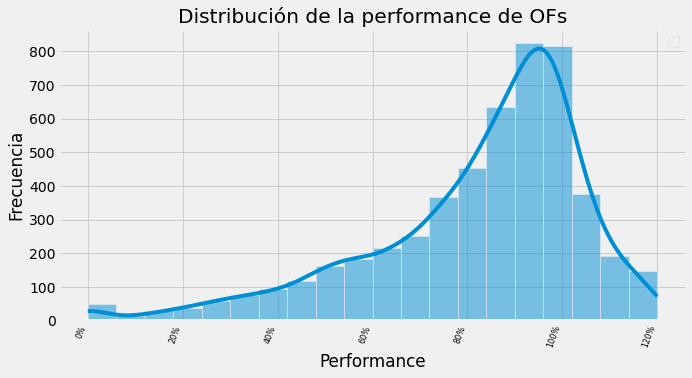

In [10]:
data = df_of.sort_values(by='performance', ascending=False)

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='performance', bins=20, kde=True)
plt.xlabel('Performance')
plt.ylabel('Frecuencia')
plt.title(f'Distribución de la performance de OFs')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.gca().xaxis.set_major_formatter(decimal_percentage_formatter_func)
plt.show()

# Distribución de Participación

In [11]:
df_operators_participation.head()

,operator_id,order,participation_minutes,total_operators_minutes,participation_percentage,of_performance,bomb_type,line,theorical_qty,participation_category,performance_category
0,5025,5160396,185.933283,185.933283,100.0,0.914306,1210,LINEA_1,2.187450,95% - 100%,90% - 100%
1,5025,5165729,251.107000,251.107000,100.0,0.681622,01224-0890,LINEA_1,2.934179,95% - 100%,60% - 70%
2,5025,5169247,391.531283,779.781233,50.2,0.923336,1197,LINEA_1,9.747265,50% - 55%,90% - 100%
3,5004,5169247,388.249950,779.781233,49.8,0.923336,1197,LINEA_1,9.747265,45% - 50%,90% - 100%
4,5004,5171973,17.021267,367.533717,4.6,0.870668,01205-0810,LINEA_1,4.594171,0% - 5%,80% - 90%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


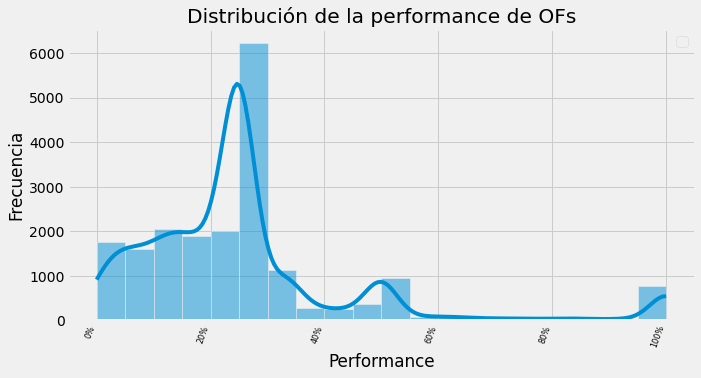

In [12]:
data = df_operators_participation.sort_values(by='participation_percentage', ascending=False)

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='participation_percentage', bins=20, kde=True)
plt.xlabel('Performance')
plt.ylabel('Frecuencia')
plt.title(f'Distribución de la performance de OFs')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().xaxis.set_major_formatter(percentage_formatter)
plt.gca().legend().set_visible(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


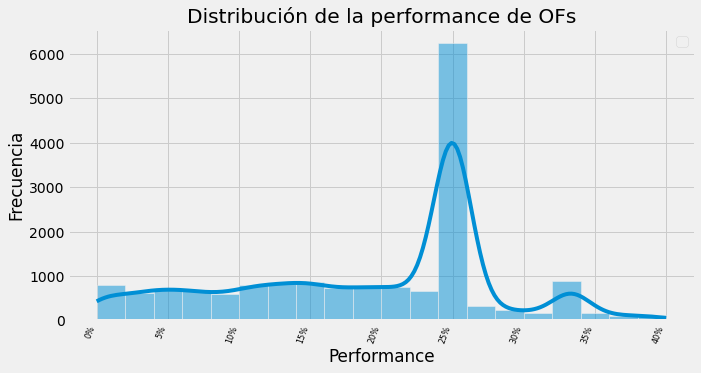

In [13]:
data = df_operators_participation[
    df_operators_participation.participation_percentage <= 40
].sort_values(by='participation_percentage', ascending=False)

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='participation_percentage', bins=20, kde=True)
plt.xlabel('Performance')
plt.ylabel('Frecuencia')
plt.title(f'Distribución de la performance de OFs')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().xaxis.set_major_formatter(percentage_formatter)
plt.gca().legend().set_visible(True)
plt.show()

In [14]:
df_operators_participation.describe()

,operator_id,order,participation_minutes,total_operators_minutes,participation_percentage,of_performance,theorical_qty
count,19736.000000,1.973600e+04,19736.000000,19736.000000,19736.000000,19736.000000,19736.000000
mean,7426.565059,5.278015e+06,263.054343,1295.672538,25.814897,0.819490,167.045972
std,2996.455197,1.332644e+05,260.145323,1176.745070,20.383601,0.219201,186.184760
min,1.000000,2.741850e+05,0.037783,0.845000,0.000000,0.000000,0.119014
25%,8164.000000,5.228260e+06,74.698383,428.290967,13.800000,0.722176,38.380738
50%,8860.000000,5.295270e+06,195.278617,1072.099025,25.000000,0.885235,125.773474
75%,9265.000000,5.327082e+06,381.847204,1854.723296,25.400000,0.968393,254.020502
max,9994.000000,5.382060e+06,2808.686350,17392.383600,100.000000,1.199976,4181.596591


# Preparación Modelo

## Supuestos

Supuestos
* Se asume un corte de performance aceptable para una OF sobre el  80%
* Se asume una participación mínima deun 5% del tiempo de un operador en una OF para considerar que trabajó en ella
* Para entrenar, se asume que la cantidad de bombas realizadas (good_qty) era lo planificado a hacer para la OF
* Se quita del análisis líneas que no son de interés para el cliente (LINEA 8 IML)

In [15]:
df_of_model = df_of.copy()
df_operators_participation_model = df_operators_participation.copy()
df_operators_model = df_operators.copy()

perfomance_cutoff = 1
participation_cutoff = 0.05
exclude_lines= ['LINEA_8_IML']

In [16]:
df_of_model.drop(['operators_distinct_ids', 'plan_qty', 'theorical_qty_round', 'performance_round', 'total_good_qty', 'total_bad_qty'], axis=1, inplace=True)
df_of_model = df_of_model[df_of_model.line.isin(exclude_lines) == False]
df_operators_participation_model = df_operators_participation_model[df_operators_participation_model.line.isin(exclude_lines) == False]  
print(df_of_model.describe())
df_of_model.head()

              order     good_qty  bad_qty  theorical_diff  theorical_time  \
count  4.146000e+03  4146.000000   4146.0     4146.000000     4146.000000   
mean   5.261866e+06   116.314279      0.0    29155.041727       22.918215   
std    9.931992e+04   149.169024      0.0    24643.329769       27.358786   
min    2.741850e+05     0.000000      0.0       26.000000        0.500000   
25%    5.207982e+06    12.000000      0.0    12127.000000        6.870000   
50%    5.256418e+06    60.000000      0.0    23888.500000        8.210000   
75%    5.315732e+06   180.000000      0.0    38405.000000       21.540000   
max    5.382060e+06  3000.000000      0.0   376798.000000       96.000000   

       time_diff_seconds_calculated  time_diff_minutes_calculated  \
count                   4146.000000                   4146.000000   
mean                   29155.048052                    485.917468   
std                    24643.315610                    410.721927   
min                       25.3

,order,bomb_type,line,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,registers_qty,operators_distinct_qty,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year
0,274185,HPS050M,LINEA_2,0.0,0.0,2020-02-28 07:47:47.760,2021-02-18 08:44:11.897,13189,13.35,13189.211,219.820183,590.426267,10,11,44.226687,0.000000,3.663670,0% - 10%,4,AM,2,2020
1,5029646,25461,LINEA 4,0.0,0.0,2020-05-26 10:42:49.543,2021-04-07 05:41:01.177,120,8.80,118.318,1.971967,3.112383,4,5,0.353680,0.000000,0.032866,0% - 10%,1,AM,5,2020
2,5070828,11509,LINEA 6,0.0,0.0,2020-04-17 05:47:54.977,2022-08-10 06:10:35.247,32671,17.40,32671.480,544.524667,594.821567,8,3,34.185148,0.000000,9.075411,0% - 10%,4,AM,4,2020
3,5157110,01226-0890,LINEA_1,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,8,1,2.458296,0.813572,3.506349,80% - 90%,0,AM,1,2020
4,5158184,11509INT,LINEA 6,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,2,4,11.835761,1.013877,0.961656,100% - 110%,5,AM,1,2020


Removemos las OFs que no tenían cantidad palnificada *good_qty == 0*

In [17]:
df_of_model = df_of_model[df_of_model.good_qty != 0]

## Etiquetado de OFs

In [18]:
df_of_model['achieve_performance'] = df_of_model['performance'].apply(lambda x: 1 if x >= perfomance_cutoff else 0)
df_of_model.head()

,order,bomb_type,line,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,registers_qty,operators_distinct_qty,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance
3,5157110,01226-0890,LINEA_1,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,8,1,2.458296,0.813572,3.506349,80% - 90%,0,AM,1,2020,0
4,5158184,11509INT,LINEA 6,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,2,4,11.835761,1.013877,0.961656,100% - 110%,5,AM,1,2020,1
5,5158571,11509INT,LINEA 6,48.0,0.0,2020-02-03 11:29:08.710,2020-02-04 09:29:27.740,22323,19.50,22323.243,372.054050,1114.680950,7,3,57.163126,0.839702,6.200901,80% - 90%,0,AM,2,2020,0
6,5159132,65566,LINEA_3,177.0,0.0,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,55912,6.87,55912.126,931.868767,1756.166533,20,2,255.628316,0.692412,15.531146,60% - 70%,3,AM,1,2020,0
7,5159134,65567,LINEA_2,270.0,0.0,2020-01-02 12:28:00.403,2020-01-08 06:20:32.553,36783,6.40,36783.083,613.051383,2446.176833,25,4,382.215130,0.706408,10.217523,70% - 80%,3,AM,1,2020,0


## Etiquetado participacion

In [19]:
df_operators_participation_model['participation_indicator'] = df_operators_participation_model['participation_percentage'].apply(lambda x: 1 if x >= participation_cutoff*100 else 0)
df_operators_participation_model.head()

,operator_id,order,participation_minutes,total_operators_minutes,participation_percentage,of_performance,bomb_type,line,theorical_qty,participation_category,performance_category,participation_indicator
0,5025,5160396,185.933283,185.933283,100.0,0.914306,1210,LINEA_1,2.187450,95% - 100%,90% - 100%,1
1,5025,5165729,251.107000,251.107000,100.0,0.681622,01224-0890,LINEA_1,2.934179,95% - 100%,60% - 70%,1
2,5025,5169247,391.531283,779.781233,50.2,0.923336,1197,LINEA_1,9.747265,50% - 55%,90% - 100%,1
3,5004,5169247,388.249950,779.781233,49.8,0.923336,1197,LINEA_1,9.747265,45% - 50%,90% - 100%,1
4,5004,5171973,17.021267,367.533717,4.6,0.870668,01205-0810,LINEA_1,4.594171,0% - 5%,80% - 90%,0


In [20]:
# Pivotear el dataframe df_operators_participation para obtener las columnas de operadores
df_operators_participation_model.drop_duplicates(inplace=True)
df_pivot = df_operators_participation_model.pivot(index='order', columns='operator_id', values='participation_indicator')
df_pivot = df_pivot.fillna(0)
df_pivot.columns = ['operator_' + str(col) for col in df_pivot.columns]
df_pivot = df_pivot.astype(int)
print(df_pivot.shape)
df_pivot.head()

(4146, 102)


,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994
order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
274185,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5029646,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5070828,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5157110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5158184,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
df_merged = pd.merge(df_of_model, df_pivot, on='order', how='left')
df_merged.head()

,order,bomb_type,line,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,registers_qty,operators_distinct_qty,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994
0,5157110,01226-0890,LINEA_1,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,8,1,2.458296,0.813572,3.506349,80% - 90%,0,AM,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5158184,11509INT,LINEA 6,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,2,4,11.835761,1.013877,0.961656,100% - 110%,5,AM,1,2020,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5158571,11509INT,LINEA 6,48.0,0.0,2020-02-03 11:29:08.710,2020-02-04 09:29:27.740,22323,19.50,22323.243,372.054050,1114.680950,7,3,57.163126,0.839702,6.200901,80% - 90%,0,AM,2,2020,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5159132,65566,LINEA_3,177.0,0.0,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,55912,6.87,55912.126,931.868767,1756.166533,20,2,255.628316,0.692412,15.531146,60% - 70%,3,AM,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5159134,65567,LINEA_2,270.0,0.0,2020-01-02 12:28:00.403,2020-01-08 06:20:32.553,36783,6.40,36783.083,613.051383,2446.176833,25,4,382.215130,0.706408,10.217523,70% - 80%,3,AM,1,2020,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
# REVISAR CASO DE OPERADOR-ORDER duplicado
#df_operators_participation_model[(df_operators_participation_model.order == 5309158) & (df_operators_participation_model.operator_id == 1)]

# Pruebas modelos

## XGBoost Classifier

In [23]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [24]:
df = df_merged.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'start_date', 'end_date', 'bad_qty', 'theorical_diff', 'total_operators_minutes', 'theorical_qty',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated',
                   'time_diff_hours_calculated', 'performance', 'performance_category'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

In [25]:
# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

In [26]:
X_encoded = pd.get_dummies(X)
X_encoded

,good_qty,theorical_time,registers_qty,operators_distinct_qty,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,turn_AM,turn_PM,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021,year_2022,year_2023
0,2.0,85.58,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,12.0,19.50,2,4,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,48.0,19.50,7,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,177.0,6.87,20,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,270.0,6.40,25,4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4100,270.0,6.87,23,7,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [27]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [28]:
# Crear el clasificador XGBoost
model = xgb.XGBClassifier(random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train, verbose=True)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

result = X_test.copy()
result['prediction'] = y_pred
result['prediction_prob'] = y_pred_proba

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))

/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:25:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precisión del modelo: 81.97%


In [29]:
df_result_complete = pd.concat([result, df_merged[df_merged.index.isin(result.index)].loc[:, ~df_merged.columns.isin(result.columns)]], axis=1)
df_result_complete.head()

,good_qty,theorical_time,registers_qty,operators_distinct_qty,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,turn_AM,turn_PM,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021,year_2022,year_2023,prediction,prediction_prob,order,bomb_type,line,bad_qty,start_date,end_date,theorical_diff,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance
6,2.0,85.00,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.137970,5160396,1210,LINEA_1,0.0,2020-01-02 05:53:20.250,2020-01-02 08:59:16.247,11156,11155.997,185.933283,185.933283,2.187450,0.914306,3.098888,90% - 100%,3,AM,1,2020,0
8,90.0,21.54,25,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.034587,5161187,8005,LINEA 6,0.0,2020-01-09 10:04:37.047,2020-01-13 07:30:49.483,49554,49553.920,825.898667,2273.027100,105.525864,0.852871,13.764978,80% - 90%,3,AM,1,2020,0
12,8.0,71.00,19,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.087659,5162165,56633-0890,LINEA_KIVU,0.0,2020-03-14 12:26:13.010,2020-03-18 14:09:47.310,38145,38145.143,635.752383,635.752383,8.954259,0.893430,10.595873,80% - 90%,5,AM,3,2020,0
14,30.0,9.96,4,4,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0.515375,5162172,72560,LINEA_2,0.0,2020-05-08 09:15:14.813,2020-05-08 10:23:49.243,4115,4114.430,68.573833,274.295333,27.539692,1.089337,1.142897,100% - 110%,4,AM,5,2020,1
17,12.0,9.8

In [30]:
df_of[df_of.order == 5294563]   

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round,time_diff_hours_calculated,performance_category,weekday,turn,month,year
2693,5294563,25463-0810,LINEA 4,50.0,45.0,0.0,24.0,0.0,2022-01-13 06:49:13.607,2022-01-13 10:43:19.590,9327,7.1,9327.01,155.450167,310.900333,"['9279', '9120']",7,2,43.788779,44.0,0.548086,0.545455,2.590836,50% - 60%,3,AM,1,2022


In [31]:
# df_result_complete[df_result_complete.achieve_performance != df_result_complete.prediction]
df_result_complete[(df_result_complete.achieve_performance == 1) & (df_result_complete.prediction == 0)]

,good_qty,theorical_time,registers_qty,operators_distinct_qty,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,turn_AM,turn_PM,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021,year_2022,year_2023,prediction,prediction_prob,order,bomb_type,line,bad_qty,start_date,end_date,theorical_diff,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance
30,7.0,20.50,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.245950,5164702,30774INT,LINEA 6,0.0,2020-02-10 11:21:28.000,2020-02-10 12:29:27.883,4079,4079.883,67.998050,135.996100,6.633956,1.055177,1.133301,100% - 110%,0,AM,2,2020,1
99,150.0,6.87,14,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0.205487,5169426,65563,LINEA_2,0.0,2020-05-21 09:01:14.780,2020-05-22 06:29:34.803,20357,20357.846,339.297433,1017.139633,148.055260,1.013135,5.654957,100% - 110%,3,AM,5,2020,1
109,12.0,80.00,16,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.020864,5170886,1195,LINEA_1,0.0,2020-01-30 10:26:38.210,2020-02-03 08:56:23.137,50196,50194.921,836.582017,870.134450,10.876681,1.103278,13.943034,0% - 10%,3,AM,1,2020,1
149,120.0,11.05,8,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.264351,5172847,15242,LINEA_3,0.0,2020-01-16 16:45:57.897,2020-01-16 21:28:42.000,16965,16964.103,282.735050,1130.940200,102.347529,1.172476,4.712251,0% - 10%,3,PM,1,2020,1
211,240

In [32]:
import numpy as np
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada con 5 divisiones
scores = cross_val_score(model, X_encoded, y, cv=5)

# Mostrar las puntuaciones de rendimiento en cada división
print("Puntuaciones de rendimiento en cada división:", scores)

# Calcular la media y desviación estándar de las puntuaciones de rendimiento
mean_score = np.mean(scores)
std_score = np.std(scores)
print("Media de las puntuaciones de rendimiento:", mean_score)
print("Desviación estándar de las puntuaciones de rendimiento:", std_score)

/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:25:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:25:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:25:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:25:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:25:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Puntuaciones de rendimiento en cada división: [0.79658952 0.80024361 0.80511571 0.77831912 0.75152253]
Media de las puntuaciones de rendimiento: 0.7863580998781974
Desviación estándar de las puntuaciones de rendimiento: 0.019634047921666148


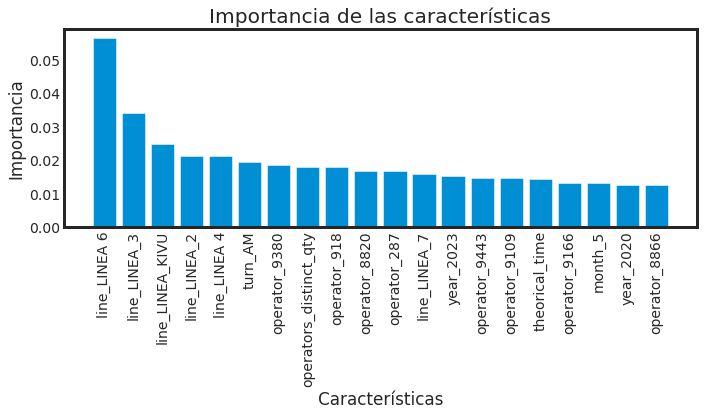

In [33]:
import matplotlib.pyplot as plt

# Obtener la importancia de las características
importances = model.feature_importances_

# Obtener los nombres de las características
feature_names = X_encoded.columns

# Ordenar las importancias y los nombres de las características en orden descendente
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices][:20]
sorted_feature_names = feature_names[indices][:20]

# Visualizar la importancia de las características en un gráfico de barras
sns.set_style('white')
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation='vertical')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las características')
plt.tight_layout()
plt.show()

In [34]:
import pandas as pd
import numpy as np

# Seleccionar las columnas relevantes para el análisis
columns = ['line_LINEA_3', 'line_LINEA_1', 'line_LINEA_2', 'good_qty', 'theorical_time', 'operator_9266', 'operator_1007', 'operator_504', 'performance']

# Crear un nuevo DataFrame con las columnas seleccionadas
df_corr = df_result_complete[columns]

# Calcular la matriz de correlación
correlation_matrix = df_corr.corr()

# Imprimir la matriz de correlación
print(correlation_matrix)

                line_LINEA_3  line_LINEA_1  line_LINEA_2  good_qty  \
line_LINEA_3        1.000000     -0.144483     -0.306143  0.007777   
line_LINEA_1       -0.144483      1.000000     -0.235113 -0.272519   
line_LINEA_2       -0.306143     -0.235113      1.000000  0.356882   
good_qty            0.007777     -0.272519      0.356882  1.000000   
theorical_time     -0.199669      0.769413     -0.395143 -0.431944   
operator_9266      -0.050546     -0.038818      0.165106  0.164291   
operator_1007       0.133173     -0.013054     -0.195163 -0.135510   
operator_504        0.715247     -0.130334     -0.230446 -0.002037   
performance        -0.190938      0.066514      0.088763  0.227621   

                theorical_time  operator_9266  operator_1007  operator_504  \
line_LINEA_3         -0.199669      -0.050546       0.133173      0.715247   
line_LINEA_1          0.769413      -0.038818      -0.013054     -0.130334   
line_LINEA_2         -0.395143       0.165106      -0.195163     

Importance Permutatios

In [35]:
from sklearn.inspection import permutation_importance

# Calcular la importancia de las permutaciones
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Obtener los puntajes de importancia
importance_scores = result.importances_mean

In [36]:
df_importance_perm = pd.DataFrame({'feature': X_encoded.columns, 'importance': result.importances_mean})

In [37]:
data = df_importance_perm[df_importance_perm.importance != 0.00]
data = df_importance_perm

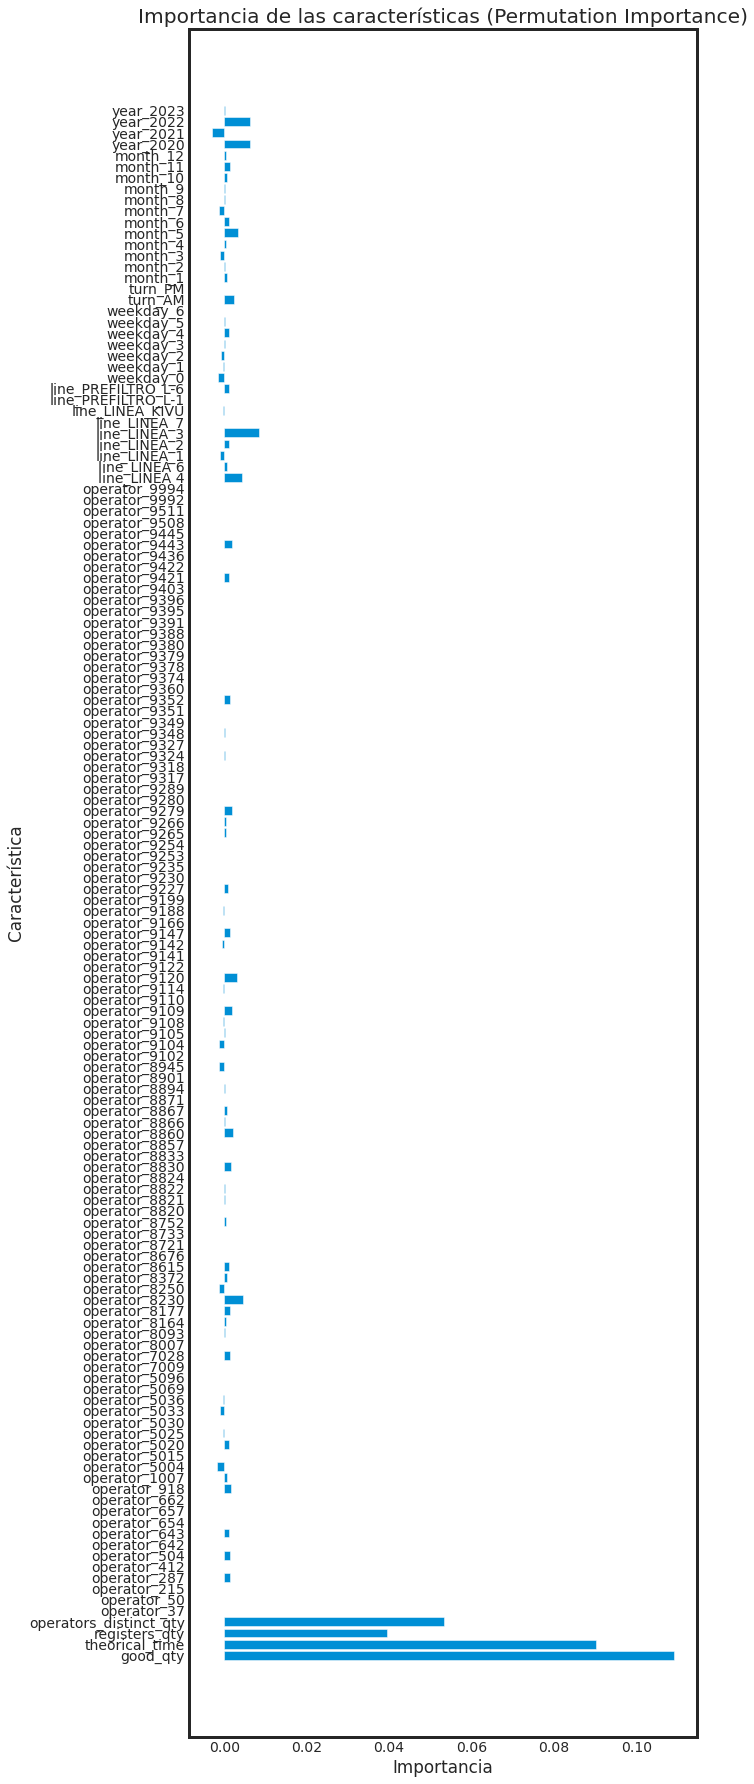

In [38]:
feature_names = data.feature
importance_scores = data.importance

# Crear un gráfico de barras de la importancia de las características
plt.figure(figsize=(10, 25))
plt.barh(feature_names, importance_scores)
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las características (Permutation Importance)')
plt.tight_layout()
plt.show()

Matriz de confusión

In [39]:
y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

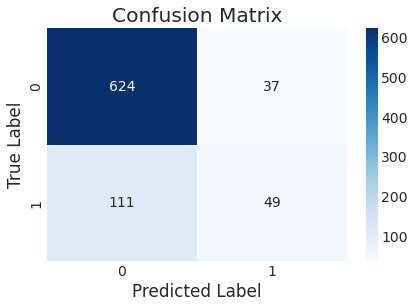

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Curva ROC

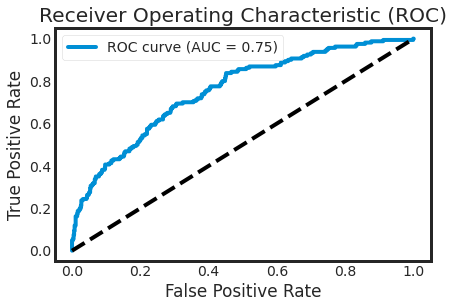

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcular las probabilidades de las clases positivas
y_prob = model.predict_proba(X_test)[:, 1]

# Calcular la tasa de falsos positivos, la tasa de verdaderos positivos y los umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcular el área bajo la curva ROC
auc = roc_auc_score(y_test, y_prob)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()


Curva precisión Recal

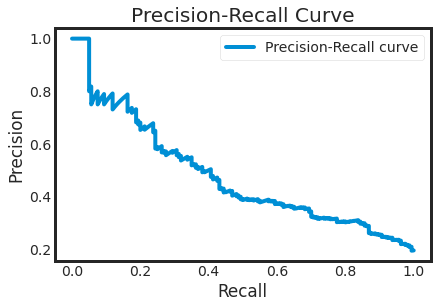

In [42]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calcular la precisión y la exhaustividad
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Graficar la curva de Precisión-Recall
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

## XGBoost Regressor | Minutos-hombre 

In [43]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [44]:
df = df_merged.copy()

TARGET = 'total_operators_minutes'
exclude_columns = ['order', 'bomb_type', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'achieve_performance', 'performance_category'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

In [45]:
# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

In [46]:
X_encoded = pd.get_dummies(X)
X_encoded

,good_qty,bad_qty,theorical_time,registers_qty,operators_distinct_qty,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,turn_AM,turn_PM,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021,year_2022,year_2023
0,2.0,0.0,85.58,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,12.0,0.0,19.50,2,4,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,48.0,0.0,19.50,7,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,177.0,0.0,6.87,20,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,270.0,0.0,6.40,25,4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4100,270.0,0.0,6.87,23,7,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [47]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [48]:
# Crear el clasificador XGBoost
model = xgb.XGBRegressor(random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train, verbose=1)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

result = X_test.copy()
result['prediction'] = y_pred



In [49]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)



print("R-squared [R2]: %.2f" % r2)
print("Mean Absolute Error [MAE]: %.2f" % mae)
print("Mean Squared Error [MSE]: %.2f" % mse)
print("Root Mean Squared Error [RMSE]: %.2f" % rmse)

R-squared [R2]: 0.96
Mean Absolute Error [MAE]: 117.53
Mean Squared Error [MSE]: 38433.82
Root Mean Squared Error [RMSE]: 196.05


Creamos la variable 'predicted_performance' para comoparar la performance real versus la calculada con la predicción

In [50]:
result['predicted_performance'] = (result.good_qty*result.theorical_time) / result.prediction
result.head()   

,good_qty,bad_qty,theorical_time,registers_qty,operators_distinct_qty,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,turn_AM,turn_PM,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021,year_2022,year_2023,prediction,predicted_performance
2470,180.0,0.0,10.00,18,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1886.719116,0.954037
564,12.0,0.0,9.83,8,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,281.606079,0.418883
731,240.0,0.0,6.87,18,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1704.441772,0.967355
1073,90.0,0.0,21.54,37,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,2304.930176,0.841067
2409,166.0,0.0,10.00,23,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2418.489502,0.686379


Join de results with the OFs dataframe

In [51]:
df_result_complete = pd.concat([result, df_merged[df_merged.index.isin(result.index)].loc[:, ~df_merged.columns.isin(result.columns)]], axis=1)
df_result_complete.head()

,good_qty,bad_qty,theorical_time,registers_qty,operators_distinct_qty,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,turn_AM,turn_PM,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021,year_2022,year_2023,prediction,predicted_performance,order,bomb_type,line,start_date,end_date,theorical_diff,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance
6,2.0,0.0,85.00,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,205.062469,0.829016,5160396,1210,LINEA_1,2020-01-02 05:53:20.250,2020-01-02 08:59:16.247,11156,11155.997,185.933283,185.933283,2.187450,0.914306,3.098888,90% - 100%,3,AM,1,2020,0
8,90.0,0.0,21.54,25,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2067.684326,0.937571,5161187,8005,LINEA 6,2020-01-09 10:04:37.047,2020-01-13 07:30:49.483,49554,49553.920,825.898667,2273.027100,105.525864,0.852871,13.764978,80% - 90%,3,AM,1,2020,0
12,8.0,0.0,71.00,19,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,760.810364,0.746572,5162165,56633-0890,LINEA_KIVU,2020-03-14 12:26:13.010,2020-03-18 14:09:47.310,38145,38145.143,635.752383,635.752383,8.954259,0.893430,10.595873,80% - 90%,5,AM,3,2020,0
14,30.0,0.0,9.96,4,4,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,262.742981,1.137233,5162172,72560,LINEA_2,2020-05-08 09:15:14.813,2020-05-08 10:23:49.243,4115,4114.430,68.573833,274.295333,27.539692,1.089337,1.1

Precisión del modelo evaluando performance

In [52]:
r2 = r2_score(df_result_complete.performance, df_result_complete.predicted_performance)
mae = mean_absolute_error(df_result_complete.performance, df_result_complete.predicted_performance)
mse = mean_squared_error(df_result_complete.performance, df_result_complete.predicted_performance)
rmse = np.sqrt(mse)



print("R-squared [R2]: %.2f" % r2)
print("Mean Absolute Error [MAE]: %.2f" % mae)
print("Mean Squared Error [MSE]: %.2f" % mse)
print("Root Mean Squared Error [RMSE]: %.2f" % rmse)

R-squared [R2]: -0.02
Mean Absolute Error [MAE]: 0.12
Mean Squared Error [MSE]: 0.03
Root Mean Squared Error [RMSE]: 0.19


Validación cruzada

In [53]:
import numpy as np
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada con 5 divisiones
scores = cross_val_score(model, X_encoded, y, cv=5)

# Mostrar las puntuaciones de rendimiento en cada división
print("Puntuaciones de rendimiento en cada división:", scores)

# Calcular la media y desviación estándar de las puntuaciones de rendimiento
mean_score = np.mean(scores)
std_score = np.std(scores)
print("Media de las puntuaciones de rendimiento:", mean_score)
print("Desviación estándar de las puntuaciones de rendimiento:", std_score)

Puntuaciones de rendimiento en cada división: [0.9584072  0.91934071 0.94447916 0.90961062 0.93533102]
Media de las puntuaciones de rendimiento: 0.933433742142847
Desviación estándar de las puntuaciones de rendimiento: 0.01740936118409234


In [54]:
comparison = pd.DataFrame({'TARGET': y_test, 'Predict': y_pred})
print(comparison)


           TARGET      Predict
2470  1845.141683  1886.719116
564    188.458667   281.606079
731   1650.169417  1704.441772
1073  1949.779100  2304.930176
2409  2212.864000  2418.489502
...           ...          ...
1018   449.432567   479.091583
2147  2190.309367  2238.707031
254   1179.964600  1252.599243
2770  1385.854250  1221.954712
2304   224.079383   384.872742

[821 rows x 2 columns]


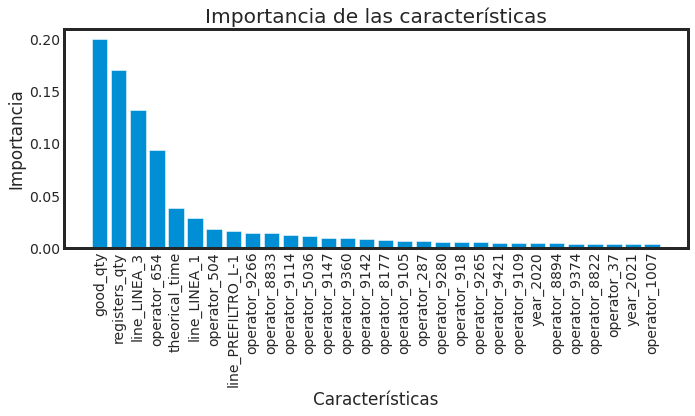

In [55]:
import matplotlib.pyplot as plt

# Obtener la importancia de las características
importances = model.feature_importances_

# Obtener los nombres de las características
feature_names = X_encoded.columns

# Ordenar las importancias y los nombres de las características en orden descendente
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices][:30]
sorted_feature_names = feature_names[indices][:30]

# Visualizar la importancia de las características en un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation='vertical')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las características')
plt.tight_layout()
plt.show()

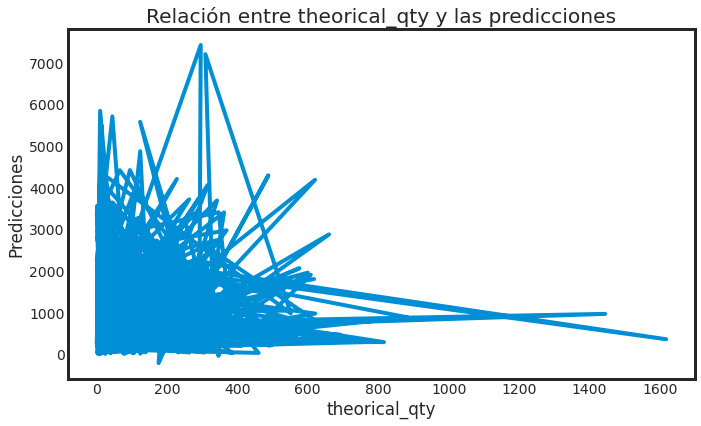

In [56]:
feature_name = 'theorical_qty'
# Graficar la relación entre la característica y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(df_result_complete[feature_name], y_pred)
plt.xlabel(feature_name)
plt.ylabel('Predicciones')
plt.title('Relación entre {} y las predicciones'.format(feature_name))
plt.show()

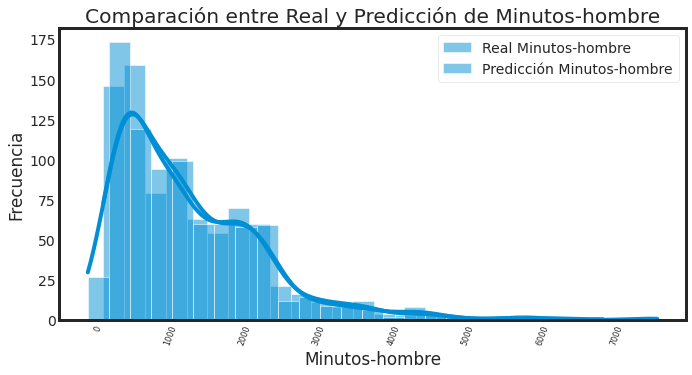

In [57]:
data = df_result_complete.sort_values(by='total_operators_minutes', ascending=False)

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='total_operators_minutes', kde=True, label='Real Minutos-hombre')
sns.histplot(data=data, x='prediction', kde=True, label='Predicción Minutos-hombre')
plt.xlabel('Minutos-hombre')
plt.ylabel('Frecuencia')
plt.title(f'Comparación entre Real y Predicción de Minutos-hombre')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.show()

## XGBoost Regressor | Performance

In [58]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [59]:
df = df_merged.copy()

TARGET = 'performance'
exclude_columns = ['order', 'bomb_type', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'total_operators_minutes',
                   'time_diff_hours_calculated', 'achieve_performance', 'performance_category'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

In [60]:
# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

In [61]:
X_encoded = pd.get_dummies(X)
X_encoded

,good_qty,bad_qty,theorical_time,registers_qty,operators_distinct_qty,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,turn_AM,turn_PM,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021,year_2022,year_2023
0,2.0,0.0,85.58,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,12.0,0.0,19.50,2,4,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,48.0,0.0,19.50,7,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,177.0,0.0,6.87,20,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,270.0,0.0,6.40,25,4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4100,270.0,0.0,6.87,23,7,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [62]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [63]:
# Crear el clasificador XGBoost
model = xgb.XGBRegressor(random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train, verbose=1)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

result = X_test.copy()
result['prediction'] = y_pred



In [64]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)



print("R-squared [R2]: %.2f" % r2)
print("Mean Absolute Error [MAE]: %.2f" % mae)
print("Mean Squared Error [MSE]: %.2f" % mse)
print("Root Mean Squared Error [RMSE]: %.2f" % rmse)

R-squared [R2]: 0.49
Mean Absolute Error [MAE]: 0.09
Mean Squared Error [MSE]: 0.02
Root Mean Squared Error [RMSE]: 0.13


Join de results with the OFs dataframe

In [65]:
df_result_complete = pd.concat([result, df_merged[df_merged.index.isin(result.index)].loc[:, ~df_merged.columns.isin(result.columns)]], axis=1)
df_result_complete.head()

,good_qty,bad_qty,theorical_time,registers_qty,operators_distinct_qty,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,turn_AM,turn_PM,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2020,year_2021,year_2022,year_2023,prediction,order,bomb_type,line,start_date,end_date,theorical_diff,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance
6,2.0,0.0,85.00,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.881030,5160396,1210,LINEA_1,2020-01-02 05:53:20.250,2020-01-02 08:59:16.247,11156,11155.997,185.933283,185.933283,2.187450,0.914306,3.098888,90% - 100%,3,AM,1,2020,0
8,90.0,0.0,21.54,25,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.892228,5161187,8005,LINEA 6,2020-01-09 10:04:37.047,2020-01-13 07:30:49.483,49554,49553.920,825.898667,2273.027100,105.525864,0.852871,13.764978,80% - 90%,3,AM,1,2020,0
12,8.0,0.0,71.00,19,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0.761988,5162165,56633-0890,LINEA_KIVU,2020-03-14 12:26:13.010,2020-03-18 14:09:47.310,38145,38145.143,635.752383,635.752383,8.954259,0.893430,10.595873,80% - 90%,5,AM,3,2020,0
14,30.0,0.0,9.96,4,4,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1.109492,5162172,72560,LINEA_2,2020-05-08 09:15:14.813,2020-05-08 10:23:49.243,4115,4114.430,68.573833,274.295333,27.539692,1.089337,1.142897,100% - 110%,4,AM,5,2020,1
17,12.0,0.0,9.83,3,1,0,0,0,0,0,0,0,

Validación cruzada

In [66]:
import numpy as np
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada con 5 divisiones
scores = cross_val_score(model, X_encoded, y, cv=5)

# Mostrar las puntuaciones de rendimiento en cada división
print("Puntuaciones de rendimiento en cada división:", scores)

# Calcular la media y desviación estándar de las puntuaciones de rendimiento
mean_score = np.mean(scores)
std_score = np.std(scores)
print("Media de las puntuaciones de rendimiento:", mean_score)
print("Desviación estándar de las puntuaciones de rendimiento:", std_score)

Puntuaciones de rendimiento en cada división: [0.36841316 0.50320011 0.43621528 0.33316796 0.274992  ]
Media de las puntuaciones de rendimiento: 0.3831977017462782
Desviación estándar de las puntuaciones de rendimiento: 0.07955057898958588


In [67]:
comparison = pd.DataFrame({'TARGET': y_test, 'Predict': y_pred})
print(comparison)


        TARGET   Predict
2470  0.975535  0.880279
564   0.625920  0.640543
731   0.999170  0.973844
1073  0.994266  0.933835
2409  0.750159  0.722078
...        ...       ...
1018  1.076914  1.094030
2147  0.972465  0.936248
254   0.873247  0.868033
2770  0.699424  0.797124
2304  1.006786  0.772183

[821 rows x 2 columns]


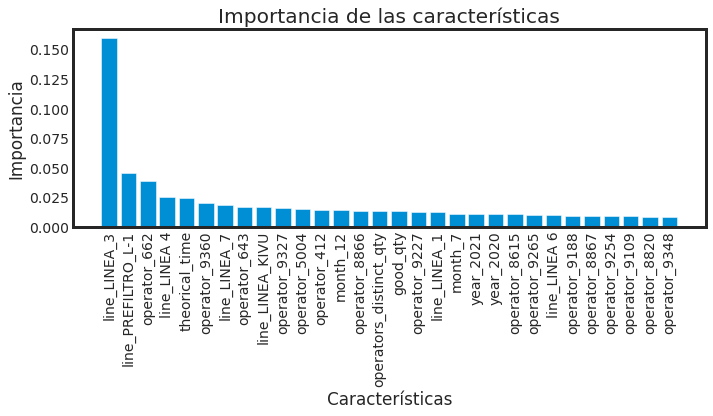

In [68]:
import matplotlib.pyplot as plt

# Obtener la importancia de las características
importances = model.feature_importances_

# Obtener los nombres de las características
feature_names = X_encoded.columns

# Ordenar las importancias y los nombres de las características en orden descendente
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices][:30]
sorted_feature_names = feature_names[indices][:30]

# Visualizar la importancia de las características en un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation='vertical')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las características')
plt.tight_layout()
plt.show()

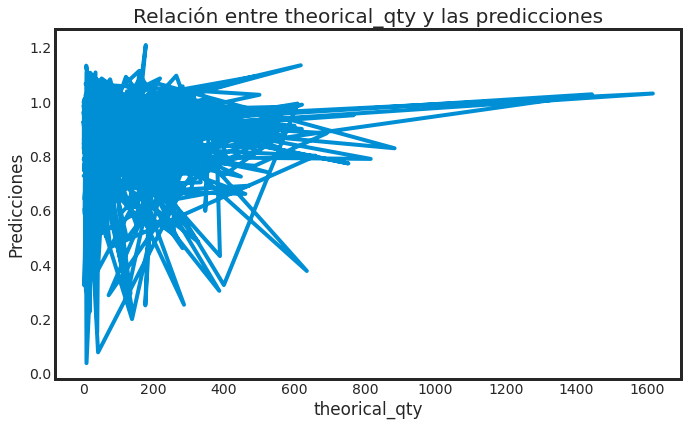

In [69]:
feature_name = 'theorical_qty'
# Graficar la relación entre la característica y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(df_result_complete[feature_name], y_pred)
plt.xlabel(feature_name)
plt.ylabel('Predicciones')
plt.title('Relación entre {} y las predicciones'.format(feature_name))
plt.show()

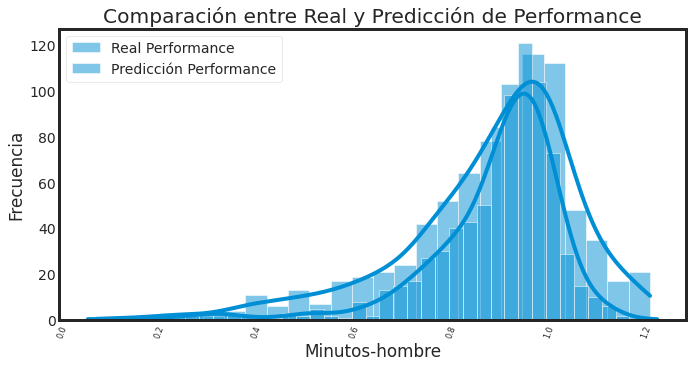

In [70]:
data = df_result_complete.sort_values(by='performance', ascending=False)

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='performance', kde=True, label='Real Performance')
sns.histplot(data=data, x='prediction', kde=True, label='Predicción Performance')
plt.xlabel('Minutos-hombre')
plt.ylabel('Frecuencia')
plt.title(f'Comparación entre Real y Predicción de Performance')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.show()

## XGBOOST REGRESSOR - PAU

Modelo teniendo en cuenta la siguiente información de entrada:

### Variable de entrada:

- line
- good_qty (Serà el plan_qty)
- theorical_time
- operator_(En este caso tendremos que ver la explicación según que pasa cuando vayan entrando nuevos operadores ya que no tendremos datos para entrar)
En este caso, lo mejor serà usar media, mediana o alguna de estas metricas para poder entrenar los nuevos operarios. En este caso no aplica

Las siguiente variables en el primer modelo será la fecha en que se va a planificar el batch de OFs
- weekday
- month
- year (Lo quitamos, ya que creo que no aporta nada el año en este caso. Ya que tendriamos que tener un vector de varios años para ir poniendo 0 o 1)

### Variable de salida:

- total_operators_minutes

In [71]:
df_merged.head()

,order,bomb_type,line,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,registers_qty,operators_distinct_qty,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994
0,5157110,01226-0890,LINEA_1,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,8,1,2.458296,0.813572,3.506349,80% - 90%,0,AM,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5158184,11509INT,LINEA 6,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,2,4,11.835761,1.013877,0.961656,100% - 110%,5,AM,1,2020,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5158571,11509INT,LINEA 6,48.0,0.0,2020-02-03 11:29:08.710,2020-02-04 09:29:27.740,22323,19.50,22323.243,372.054050,1114.680950,7,3,57.163126,0.839702,6.200901,80% - 90%,0,AM,2,2020,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5159132,65566,LINEA_3,177.0,0.0,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,55912,6.87,55912.126,931.868767,1756.166533,20,2,255.628316,0.692412,15.531146,60% - 70%,3,AM,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5159134,65567,LINEA_2,270.0,0.0,2020-01-02 12:28:00.403,2020-01-08 06:20:32.553,36783,6.40,36783.083,613.051383,2446.176833,25,4,382.215130,0.706408,10.217523,70% - 80%,3,AM,1,2020,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
# Filtrar las columnas que comienzan por "operator_"
filtered_columns = [col for col in df_merged.columns if col.startswith('operator_')]

# Mostrar las columnas filtradas en una lista
column_list = filtered_columns
print(column_list)
print(len(column_list))

['operator_37', 'operator_50', 'operator_215', 'operator_287', 'operator_412', 'operator_504', 'operator_642', 'operator_643', 'operator_654', 'operator_657', 'operator_662', 'operator_918', 'operator_1007', 'operator_5004', 'operator_5015', 'operator_5020', 'operator_5025', 'operator_5030', 'operator_5033', 'operator_5036', 'operator_5069', 'operator_5096', 'operator_7009', 'operator_7028', 'operator_8007', 'operator_8093', 'operator_8164', 'operator_8177', 'operator_8230', 'operator_8250', 'operator_8372', 'operator_8615', 'operator_8676', 'operator_8721', 'operator_8733', 'operator_8752', 'operator_8820', 'operator_8821', 'operator_8822', 'operator_8824', 'operator_8830', 'operator_8833', 'operator_8857', 'operator_8860', 'operator_8866', 'operator_8867', 'operator_8871', 'operator_8894', 'operator_8901', 'operator_8945', 'operator_9102', 'operator_9104', 'operator_9105', 'operator_9108', 'operator_9109', 'operator_9110', 'operator_9114', 'operator_9120', 'operator_9122', 'operator_

In [73]:
df = df_merged.copy()

TARGET = 'total_operators_minutes'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'achieve_performance', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

In [74]:
# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

In [75]:
X_encoded = pd.get_dummies(X)
X_encoded

,good_qty,theorical_time,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2.0,85.58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,12.0,19.50,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,48.0,19.50,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,177.0,6.87,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,270.0,6.40,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4100,270.0,6.87,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4101,540.0,6.87,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,

In [76]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

### Modelo directo de Enrique

In [77]:
# Crear el clasificador XGBoost
model = xgb.XGBRegressor(random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train, verbose=1)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

result = X_test.copy()
result['prediction'] = y_pred


In [78]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)



print("R-squared [R2]: %3f" % r2)
print("Mean Absolute Error [MAE]: %.2f" % mae)
print("Mean Squared Error [MSE]: %.2f" % mse)
print("Root Mean Squared Error [RMSE]: %.2f" % rmse)

R-squared [R2]: 0.955812
Mean Absolute Error [MAE]: 118.16
Mean Squared Error [MSE]: 44257.07
Root Mean Squared Error [RMSE]: 210.37


### Modelo realizando un escalado en dos variables

In [79]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Crear una instancia del MinMaxScaler y aplicar el escalado
scaler = MinMaxScaler()


In [80]:
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])

# Realizar la inversión del escalado
df_inverse = pd.DataFrame(scaler.inverse_transform(df_scaled), columns=['good_qty', 'theorical_time'])


# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)

# Eliminar dos columnas del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

X_encoded_scaled.head()

,good_qty_scaled,theorical_time_scaled,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,line_PREFILTRO_L-1,line_PREFILTRO_L-6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0.000333,0.890890,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0.003668,0.198953,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0.015672,0.198953,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0.058686,0.066702,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0.089697,0.061780,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [81]:
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Mostrar la serie escalada
print(y_scaled)

# Revertir el escalado y obtener los valores originales
y_inverse = scaler.inverse_transform(y_scaled)

# Convertir el arreglo NumPy resultante a una serie de pandas
y_original = pd.Series(y_inverse.flatten())

# Mostrar la serie original
print(y_original)


[[0.02137494]
 [0.02347646]
 [0.11445685]
 ...
 [0.11318585]
 [0.05830705]
 [0.13692856]]
0        210.380933
1        230.797333
2       1114.680950
3       1756.166533
4       2446.176833
           ...     
4100    1941.383633
4101    3994.120200
4102    1102.333133
4103     569.180067
4104    1332.995883
Length: 4105, dtype: float64


In [82]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_encoded_scaled, y_scaled, test_size=0.2, random_state=42)

In [83]:
# Crear el clasificador XGBoost
model = xgb.XGBRegressor(random_state=42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train_scaled, verbose=1)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)

result = X_test_scaled.copy()
result['prediction'] = y_pred


In [84]:
# Revertir el escalado y obtener los valores originales
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_pred = pd.Series(y_pred.flatten())

y_test_scaled = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
y_test_scaled = pd.Series(y_test_scaled.flatten())

In [85]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2 = r2_score(y_test_scaled, y_pred)
mae = mean_absolute_error(y_test_scaled, y_pred)
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)



print("R-squared [R2]: %3f" % r2)
print("Mean Absolute Error [MAE]: %.2f" % mae)
print("Mean Squared Error [MSE]: %.2f" % mse)
print("Root Mean Squared Error [RMSE]: %.2f" % rmse)

R-squared [R2]: 0.961473
Mean Absolute Error [MAE]: 112.78
Mean Squared Error [MSE]: 38587.79
Root Mean Squared Error [RMSE]: 196.44


### Error modelo Enrique

- R-squared [R2]: 0.955812
- Mean Absolute Error [MAE]: 118.16
- Mean Squared Error [MSE]: 44257.07
- Root Mean Squared Error [RMSE]: 210.37

### Error modelo Pau

- R-squared [R2]: 0.961473
- Mean Absolute Error [MAE]: 112.78
- Mean Squared Error [MSE]: 38587.79
- Root Mean Squared Error [RMSE]: 196.44

### Hyperparameters of XGBRegressor

In [86]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_encoded_scaled, y_scaled, test_size=0.2, random_state=42)

Primeros parametros:


        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)


In [87]:
'''
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Definir la función objetivo para la optimización de Optuna
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 3),
        'gamma': trial.suggest_float('gamma', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.9, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.4, 0.6),
        'random_state': 42
    }

    # Crear el modelo XGBRegressor con los hiperparámetros propuestos
    model = xgb.XGBRegressor(**params)

    # Entrenar el modelo
    model.fit(X_train_scaled, y_train_scaled)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_scaled)

    # Invertir la transformación sobre y_pred
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_pred = pd.Series(y_pred.flatten())

    # Invertir la transformación sobre y_test_scaled
    y_test = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
    y_test = pd.Series(y_test.flatten())

    # Calcular el error MSE
    mse = mean_squared_error(y_test, y_pred)

    return mse

# Crear el estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Obtener los mejores hiperparámetros encontrados
best_params = study.best_params
'''

"\nimport optuna\nimport xgboost as xgb\nfrom sklearn.metrics import mean_squared_error\nfrom sklearn.model_selection import train_test_split\n\n# Definir la función objetivo para la optimización de Optuna\ndef objective(trial):\n    params = {\n        'max_depth': trial.suggest_int('max_depth', 6, 10),\n        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),\n        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),\n        'min_child_weight': trial.suggest_int('min_child_weight', 1, 3),\n        'gamma': trial.suggest_float('gamma', 0.01, 0.1),\n        'subsample': trial.suggest_float('subsample', 0.7, 0.9),\n        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.9, 1.0),\n        'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 1.0),\n        'reg_lambda': trial.suggest_float('reg_lambda', 0.4, 0.6),\n        'random_state': 42\n    }\n\n    # Crear el modelo XGBRegressor con los hiperparámetros propuestos\n    model = xgb.XGBRegress

In [89]:
'''
# Obtener los mejores parámetros encontrados
best_params = study.best_params

# Imprimir los mejores parámetros
print("Mejores hiperparámetros encontrados:")
for key, value in best_params.items():
    print(f"- {key}: {value}")
'''

'\n# Obtener los mejores parámetros encontrados\nbest_params = study.best_params\n\n# Imprimir los mejores parámetros\nprint("Mejores hiperparámetros encontrados:")\nfor key, value in best_params.items():\n    print(f"- {key}: {value}")\n'

Mejores hiperparámetros encontrados:
- max_depth: 7
- learning_rate: 0.04215891448546176
- n_estimators: 802
- min_child_weight: 2
- gamma: 0.010299087705971835
- subsample: 0.7665097955177043
- colsample_bytree: 0.9320282195461901
- reg_alpha: 0.5086408853746989
- reg_lambda: 0.429196612685647

In [90]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_encoded_scaled, y_scaled, test_size=0.2, random_state=42)

In [91]:
# Definir los mejores hiperparámetros encontrados
best_params = {
    'max_depth': 7,
    'learning_rate': 0.04215891448546176,
    'n_estimators': 802,
    'min_child_weight': 2,
    'gamma': 0.010299087705971835,
    'subsample': 0.7665097955177043,
    'colsample_bytree': 0.9320282195461901,
    'reg_alpha': 0.5086408853746989,
    'reg_lambda': 0.429196612685647,
    'random_state': 42
}

# Crear el modelo XGBRegressor con los mejores hiperparámetros
model = xgb.XGBRegressor(**best_params)

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train_scaled, y_train_scaled)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)

In [92]:
# Revertir el escalado y obtener los valores originales
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_pred = pd.Series(y_pred.flatten())

y_test_scaled = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
y_test_scaled = pd.Series(y_test_scaled.flatten())

In [93]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2 = r2_score(y_test_scaled, y_pred)
mae = mean_absolute_error(y_test_scaled, y_pred)
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)


print("R-squared [R2]: %3f" % r2)
print("Mean Absolute Error [MAE]: %.2f" % mae)
print("Mean Squared Error [MSE]: %.2f" % mse)
print("Root Mean Squared Error [RMSE]: %.2f" % rmse)

R-squared [R2]: 0.958847
Mean Absolute Error [MAE]: 128.91
Mean Squared Error [MSE]: 41217.17
Root Mean Squared Error [RMSE]: 203.02


Podemos hacer la ultima prueba, de ejecutar con rangos de los parametros mas grandes.

Vamos a eliminar algunos registros,vamos hacer feature engineering...

In [94]:
df_merged.head()

,order,bomb_type,line,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,registers_qty,operators_distinct_qty,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994
0,5157110,01226-0890,LINEA_1,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,8,1,2.458296,0.813572,3.506349,80% - 90%,0,AM,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5158184,11509INT,LINEA 6,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,2,4,11.835761,1.013877,0.961656,100% - 110%,5,AM,1,2020,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5158571,11509INT,LINEA 6,48.0,0.0,2020-02-03 11:29:08.710,2020-02-04 09:29:27.740,22323,19.50,22323.243,372.054050,1114.680950,7,3,57.163126,0.839702,6.200901,80% - 90%,0,AM,2,2020,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5159132,65566,LINEA_3,177.0,0.0,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,55912,6.87,55912.126,931.868767,1756.166533,20,2,255.628316,0.692412,15.531146,60% - 70%,3,AM,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5159134,65567,LINEA_2,270.0,0.0,2020-01-02 12:28:00.403,2020-01-08 06:20:32.553,36783,6.40,36783.083,613.051383,2446.176833,25,4,382.215130,0.706408,10.217523,70% - 80%,3,AM,1,2020,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [95]:
# Filtrar los registros que comienzan con "PREFILTER"
df = df_merged[~df_merged['line'].str.startswith('PREFILTRO')]
#df = df_merged.copy()

TARGET = 'total_operators_minutes'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'achieve_performance', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

In [96]:
# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

In [97]:
X_encoded = pd.get_dummies(X)
X_encoded

,good_qty,theorical_time,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2.0,85.58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,12.0,19.50,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,48.0,19.50,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,177.0,6.87,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,270.0,6.40,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4100,270.0,6.87,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4101,540.0,6.87,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,

In [98]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Crear una instancia del MinMaxScaler y aplicar el escalado
scaler = MinMaxScaler()


In [99]:
# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])

# Restablecer los índices de df_scaled y X_encoded
df_scaled.reset_index(drop=True, inplace=True)
X_encoded.reset_index(drop=True, inplace=True)

# Realizar la inversión del escalado
df_inverse = pd.DataFrame(scaler.inverse_transform(df_scaled), columns=['good_qty', 'theorical_time'])

# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)

# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

# Imprimir el dataframe resultante
X_encoded_scaled

,good_qty_scaled,theorical_time_scaled,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0.000333,0.890890,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0.003668,0.198953,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0.015672,0.198953,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0.058686,0.066702,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0.089697,0.061780,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3976,0.089697,0.066702,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3977,0.179727,0.066702,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,

In [100]:
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Mostrar la serie escalada
print(y_scaled)

# Revertir el escalado y obtener los valores originales
y_inverse = scaler.inverse_transform(y_scaled)

# Convertir el arreglo NumPy resultante a una serie de pandas
y_original = pd.Series(y_inverse.flatten())

# Mostrar la serie original
print(y_original)

[[0.02137494]
 [0.02347646]
 [0.11445685]
 ...
 [0.11318585]
 [0.05830705]
 [0.13692856]]
0        210.380933
1        230.797333
2       1114.680950
3       1756.166533
4       2446.176833
           ...     
3976    1941.383633
3977    3994.120200
3978    1102.333133
3979     569.180067
3980    1332.995883
Length: 3981, dtype: float64


In [101]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_encoded_scaled, y_scaled, test_size=0.2, random_state=42)

In [102]:
# Crear el clasificador XGBoost
model = xgb.XGBRegressor(random_state=42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train_scaled, verbose=1)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)

result = X_test_scaled.copy()
result['prediction'] = y_pred

In [103]:
# Revertir el escalado y obtener los valores originales
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_pred = pd.Series(y_pred.flatten())

y_test_scaled = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
y_test_scaled = pd.Series(y_test_scaled.flatten())

In [104]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2 = r2_score(y_test_scaled, y_pred)
mae = mean_absolute_error(y_test_scaled, y_pred)
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)



print("R-squared [R2]: %3f" % r2)
print("Mean Absolute Error [MAE]: %.2f" % mae)
print("Mean Squared Error [MSE]: %.2f" % mse)
print("Root Mean Squared Error [RMSE]: %.2f" % rmse)

R-squared [R2]: 0.925664
Mean Absolute Error [MAE]: 123.23
Mean Squared Error [MSE]: 70580.55
Root Mean Squared Error [RMSE]: 265.67


Quitando las lineas de prefiltros que como dijo Sergio no son de montaje de Bombas

In [105]:
X_encoded_scaled

,good_qty_scaled,theorical_time_scaled,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0.000333,0.890890,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0.003668,0.198953,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0.015672,0.198953,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0.058686,0.066702,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0.089697,0.061780,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3976,0.089697,0.066702,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3977,0.179727,0.066702,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,

In [106]:
# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled['grupo_qty'] = pd.cut(X_encoded_scaled['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)

# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled = pd.get_dummies(X_encoded_scaled, columns=['grupo_qty'])

# Imprimir el DataFrame resultante
X_encoded_scaled

,good_qty_scaled,theorical_time_scaled,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,grupo_qty_0,grupo_qty_1,grupo_qty_2,grupo_qty_3,grupo_qty_4
0,0.000333,0.890890,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.003668,0.198953,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0.015672,0.198953,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.058686,0.066702,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.089697,0.061780,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3976,0.089697,0.066702,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0

Creamos variable del tiempo OF (Multiplicación cantidad por theorical time)

In [107]:
# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled['time_of'] = X_encoded_scaled['good_qty_scaled'] * X_encoded_scaled['theorical_time_scaled']

X_encoded_scaled

,good_qty_scaled,theorical_time_scaled,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,grupo_qty_0,grupo_qty_1,grupo_qty_2,grupo_qty_3,grupo_qty_4,time_of
0,0.000333,0.890890,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.000297
1,0.003668,0.198953,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.000730
2,0.015672,0.198953,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.003118
3,0.058686,0.066702,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.003914
4,0.089697,0.061780,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.005541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3976,0.089697,0.066702,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [108]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_encoded_scaled, y_scaled, test_size=0.2, random_state=42)

In [109]:
# Crear el clasificador XGBoost
model = xgb.XGBRegressor(random_state=42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train_scaled, verbose=1)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)

result = X_test_scaled.copy()
result['prediction'] = y_pred

In [110]:
# Revertir el escalado y obtener los valores originales
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_pred = pd.Series(y_pred.flatten())

y_test_scaled = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
y_test_scaled = pd.Series(y_test_scaled.flatten())

In [111]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2 = r2_score(y_test_scaled, y_pred)
mae = mean_absolute_error(y_test_scaled, y_pred)
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)



print("R-squared [R2]: %3f" % r2)
print("Mean Absolute Error [MAE]: %.2f" % mae)
print("Mean Squared Error [MSE]: %.2f" % mse)
print("Root Mean Squared Error [RMSE]: %.2f" % rmse)

R-squared [R2]: 0.941644
Mean Absolute Error [MAE]: 120.79
Mean Squared Error [MSE]: 55407.70
Root Mean Squared Error [RMSE]: 235.39


Con los nuevos campos

- R-squared [R2]: 0.941644
- Mean Absolute Error [MAE]: 120.79
- Mean Squared Error [MSE]: 55407.70
- Root Mean Squared Error [RMSE]: 235.39

Miramos correlaciones entre variables, por si podemos eliminar alguna que nos pueda estar empeorando el modelo

In [112]:
import pandas as pd

# Calcular la matriz de correlación
correlation_matrix = X_encoded_scaled.corr()

# Imprimir la matriz de correlación
print(correlation_matrix)

                       good_qty_scaled  theorical_time_scaled  operator_37  \
good_qty_scaled               1.000000              -0.426632    -0.002661   
theorical_time_scaled        -0.426632               1.000000    -0.033348   
operator_37                  -0.002661              -0.033348     1.000000   
operator_50                        NaN                    NaN          NaN   
operator_215                 -0.023088              -0.003458    -0.002962   
...                                ...                    ...          ...   
grupo_qty_1                   0.395264              -0.049006     0.039026   
grupo_qty_2                   0.188973              -0.015827    -0.001709   
grupo_qty_3                   0.239590              -0.012916    -0.001208   
grupo_qty_4                   0.302644              -0.012762    -0.001208   
time_of                       0.783872              -0.292385     0.012291   

                       operator_50  operator_215  operator_287 

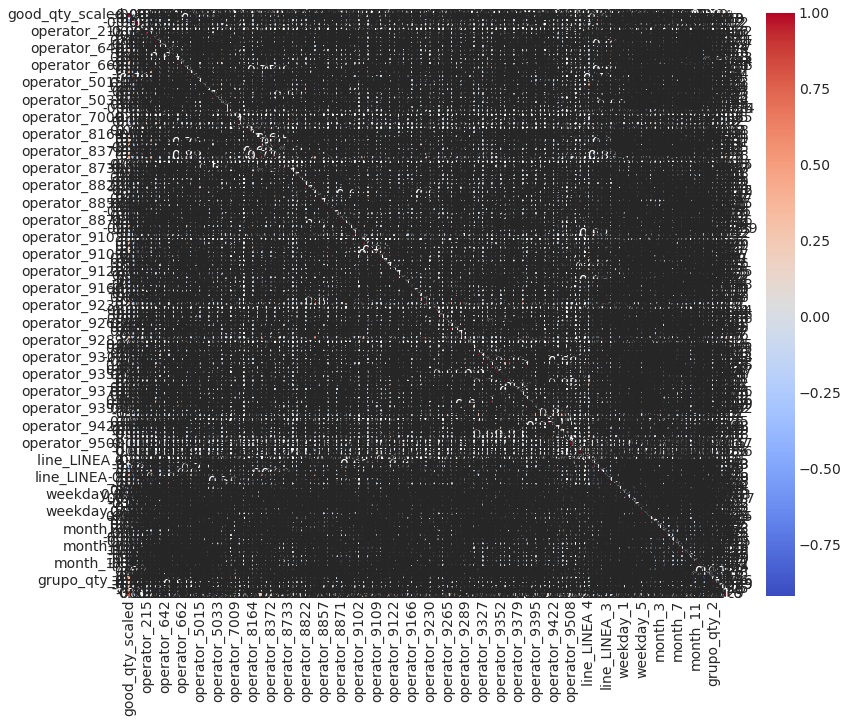

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlation_matrix = X_encoded_scaled.corr()

# Generar el mapa de calor de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

# Mostrar el mapa de calor
plt.show()

In [114]:
import pandas as pd

# Calcular la matriz de correlación
correlation_matrix = X_encoded_scaled.corr()

# Establecer el umbral de correlación
umbral_correlacion = 0.9

# Encontrar las columnas altamente correlacionadas
columnas_correlacionadas = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > umbral_correlacion:
            columna = correlation_matrix.columns[i]
            columnas_correlacionadas.add(columna)

# Imprimir las columnas altamente correlacionadas
print("Columnas altamente correlacionadas:")
print(columnas_correlacionadas)

# Decidir qué columnas eliminar
columnas_eliminar = list(columnas_correlacionadas)

Columnas altamente correlacionadas:
{'grupo_qty_1', 'operator_9352', 'operator_9388'}


In [115]:
print(columnas_eliminar)

['grupo_qty_1', 'operator_9352', 'operator_9388']


In [116]:
# ... Puedes aplicar tu lógica para decidir qué columnas eliminar ...

# Eliminar las columnas del DataFrame original
X_encoded_scaled_filtrado = X_encoded_scaled.drop(columns=['grupo_qty_1'])

# Imprimir el DataFrame resultante
print("DataFrame después de eliminar columnas correlacionadas:")
X_encoded_scaled_filtrado

DataFrame después de eliminar columnas correlacionadas:


,good_qty_scaled,theorical_time_scaled,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,grupo_qty_0,grupo_qty_2,grupo_qty_3,grupo_qty_4,time_of
0,0.000333,0.890890,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000297
1,0.003668,0.198953,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000730
2,0.015672,0.198953,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.003118
3,0.058686,0.066702,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.003914
4,0.089697,0.061780,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.005541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3976,0.089697,0.066702,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [117]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_encoded_scaled_filtrado, y_scaled, test_size=0.2, random_state=42)

In [118]:
# Crear el clasificador XGBoost
model = xgb.XGBRegressor(random_state=42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train_scaled, verbose=1)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)

result = X_test_scaled.copy()
result['prediction'] = y_pred

In [119]:
# Revertir el escalado y obtener los valores originales
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_pred = pd.Series(y_pred.flatten())

y_test_scaled = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
y_test_scaled = pd.Series(y_test_scaled.flatten())

In [120]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2 = r2_score(y_test_scaled, y_pred)
mae = mean_absolute_error(y_test_scaled, y_pred)
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)



print("R-squared [R2]: %3f" % r2)
print("Mean Absolute Error [MAE]: %.2f" % mae)
print("Mean Squared Error [MSE]: %.2f" % mse)
print("Root Mean Squared Error [RMSE]: %.2f" % rmse)

R-squared [R2]: 0.940762
Mean Absolute Error [MAE]: 121.08
Mean Squared Error [MSE]: 56245.16
Root Mean Squared Error [RMSE]: 237.16


Eliminando una de la variable mas correlacionado con otras no conseguimos tampoco un mejor resultado.

Vamos aplicar, con la casuistica de arriba que hemos sacado el mejor resultado

In [121]:
df_last_model = df_merged[~df_merged['line'].str.startswith('PREFILTRO')]

df_last_model


,order,bomb_type,line,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,registers_qty,operators_distinct_qty,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994
0,5157110,01226-0890,LINEA_1,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,8,1,2.458296,0.813572,3.506349,80% - 90%,0,AM,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5158184,11509INT,LINEA 6,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,2,4,11.835761,1.013877,0.961656,100% - 110%,5,AM,1,2020,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5158571,11509INT,LINEA 6,48.0,0.0,2020-02-03 11:29:08.710,2020-02-04 09:29:27.740,22323,19.50,22323.243,372.054050,1114.680950,7,3,57.163126,0.839702,6.200901,80% - 90%,0,AM,2,2020,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5159132,65566,LINEA_3,177.0,0.0,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,55912,6.87,55912.126,931.868767,1756.166533,20,2,255.628316,0.692412,15.531146,60% - 70%,3,AM,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5159134,65567,LINEA_2,270.0,0.0,2020-01-02 12:28:00.403,2020-01-08 06:20:32.553,36783,6.40,36783.083,613.051383,2446.176833,25,4,382.215130,0.706408,10.217523,70% - 80%,3,AM,1,2020,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## LAST MODEL - WITH OPTIMIZER HYPERPARAMETERS OPTUNA (3000 ITERATIONS)

In [153]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Ruta completa del archivo CSV
ruta_archivo = 'data/processed_csv/df_model_final.csv'

# Leer el archivo CSV en un DataFrame
df_model_final = pd.read_csv(ruta_archivo)

# Crear una instancia del MinMaxScaler y aplicar el escalado
scaler = MinMaxScaler()

df = df_model_final.copy()

TARGET = 'total_operators_minutes'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'achieve_performance', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

# Realizar el escalado de las columnas 'y'
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled['grupo_qty'] = pd.cut(X_encoded_scaled['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled = pd.get_dummies(X_encoded_scaled, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled['time_of'] = X_encoded_scaled['good_qty_scaled'] * X_encoded_scaled['theorical_time_scaled']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_encoded_scaled, y_scaled, test_size=0.2, random_state=42)

In [123]:
'''
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Definir la función objetivo para la optimización de Optuna
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 3),
        'gamma': trial.suggest_float('gamma', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.9, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.4, 0.6),
        'random_state': 42
    }

    # Crear el modelo XGBRegressor con los hiperparámetros propuestos
    model = xgb.XGBRegressor(**params)

    # Entrenar el modelo
    model.fit(X_train_scaled, y_train_scaled)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_scaled)

    # Invertir la transformación sobre y_pred
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_pred = pd.Series(y_pred.flatten())

    # Invertir la transformación sobre y_test_scaled
    y_test = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
    y_test = pd.Series(y_test.flatten())

    # Calcular el error MSE
    mse = mean_squared_error(y_test, y_pred)

    return mse

# Crear el estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3000)

# Obtener los mejores hiperparámetros encontrados
best_params = study.best_params
'''

"\nimport optuna\nimport xgboost as xgb\nfrom sklearn.metrics import mean_squared_error\nfrom sklearn.model_selection import train_test_split\n\n# Definir la función objetivo para la optimización de Optuna\ndef objective(trial):\n    params = {\n        'max_depth': trial.suggest_int('max_depth', 6, 10),\n        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),\n        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),\n        'min_child_weight': trial.suggest_int('min_child_weight', 1, 3),\n        'gamma': trial.suggest_float('gamma', 0.01, 0.1),\n        'subsample': trial.suggest_float('subsample', 0.7, 0.9),\n        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.9, 1.0),\n        'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 1.0),\n        'reg_lambda': trial.suggest_float('reg_lambda', 0.4, 0.6),\n        'random_state': 42\n    }\n\n    # Crear el modelo XGBRegressor con los hiperparámetros propuestos\n    model = xgb.XGBRegress

In [124]:
'''
# Imprimir los mejores parámetros
print("Mejores hiperparámetros encontrados:")
for key, value in best_params.items():
    print(f"- {key}: {value}")
'''

'\n# Imprimir los mejores parámetros\nprint("Mejores hiperparámetros encontrados:")\nfor key, value in best_params.items():\n    print(f"- {key}: {value}")\n'

Mejores hiperparámetros encontrados:
- max_depth: 10
- learning_rate: 0.28073606297204146
- n_estimators: 800
- min_child_weight: 3
- gamma: 0.010005371006274282
- subsample: 0.8585833713679496
- colsample_bytree: 0.9760168186928367
- reg_alpha: 0.5462214645355881
- reg_lambda: 0.5889848097912264

In [154]:
# Crear el clasificador XGBoost
model = xgb.XGBRegressor(random_state=42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train_scaled, verbose=1)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)

result = X_test_scaled.copy()
result['prediction'] = y_pred

# Revertir el escalado y obtener los valores originales
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_pred = pd.Series(y_pred.flatten())

y_test = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
y_test = pd.Series(y_test.flatten())

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R-squared [R2]: %3f" % r2)
print("Mean Absolute Error [MAE]: %.2f" % mae)
print("Mean Squared Error [MSE]: %.2f" % mse)
print("Root Mean Squared Error [RMSE]: %.2f" % rmse)

R-squared [R2]: 0.941644
Mean Absolute Error [MAE]: 120.79
Mean Squared Error [MSE]: 55407.70
Root Mean Squared Error [RMSE]: 235.39


In [126]:
# Crear el clasificador XGBoost con los mejores hiperparámetros
model = xgb.XGBRegressor(
    max_depth=10,
    learning_rate=0.28073606297204146,
    n_estimators=800,
    min_child_weight=3,
    gamma=0.010005371006274282,
    subsample=0.8585833713679496,
    colsample_bytree=0.9760168186928367,
    reg_alpha=0.5462214645355881,
    reg_lambda=0.5889848097912264,
    random_state=42
)

# Entrenar el modelo con los datos escalados
model.fit(X_train_scaled, y_train_scaled, verbose=1)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)

result = X_test_scaled.copy()
result['prediction'] = y_pred

# Revertir el escalado y obtener los valores originales
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_pred = pd.Series(y_pred.flatten())

y_test = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))
y_test = pd.Series(y_test.flatten())

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R-squared [R2]: %3f" % r2)
print("Mean Absolute Error [MAE]: %.2f" % mae)
print("Mean Squared Error [MSE]: %.2f" % mse)
print("Root Mean Squared Error [RMSE]: %.2f" % rmse)

R-squared [R2]: 0.936861
Mean Absolute Error [MAE]: 135.58
Mean Squared Error [MSE]: 59949.00
Root Mean Squared Error [RMSE]: 244.84


Los errores con el regressor son demasiados grandes.Vamos analizar la duración de las OFs, por ver que pasa si hacemos dos modelos separados por tiempo de las OFs.

### Separar modelos por tiempo

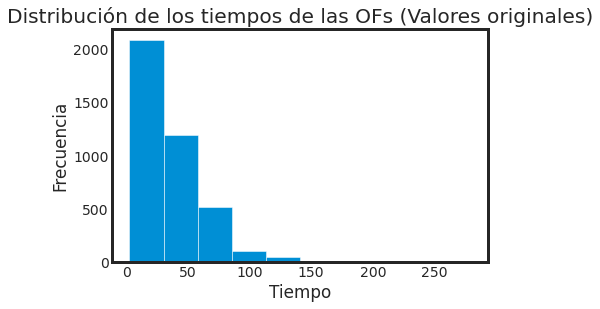

count    3981.000000
mean       34.832902
std        28.646408
min         2.721217
25%        13.050133
50%        28.434281
75%        53.154820
max       279.730872
Name: time_of_inverted, dtype: float64


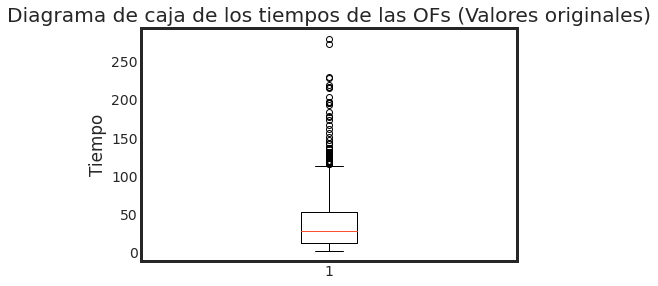

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

# Carga el dataframe
data = X_encoded_scaled.copy()

# Invierte la escala de la columna "time_of"
data['time_of_inverted'] = scaler.inverse_transform(data[['time_of']])

# Visualización del histograma de los valores invertidos
plt.hist(data['time_of_inverted'], bins=10)
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')
plt.title('Distribución de los tiempos de las OFs (Valores originales)')
plt.show()

# Estadísticas descriptivas de los valores invertidos
stats = data['time_of_inverted'].describe()
print(stats)

# Box plot de los valores invertidos
plt.boxplot(data['time_of_inverted'])
plt.ylabel('Tiempo')
plt.title('Diagrama de caja de los tiempos de las OFs (Valores originales)')
plt.show()



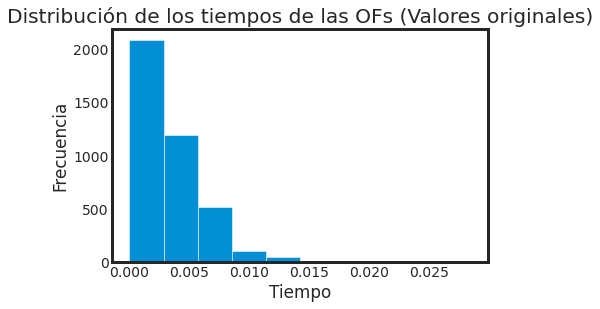

count    3981.000000
mean        0.003305
std         0.002949
min         0.000000
25%         0.001063
50%         0.002647
75%         0.005191
max         0.028513
Name: time_of, dtype: float64


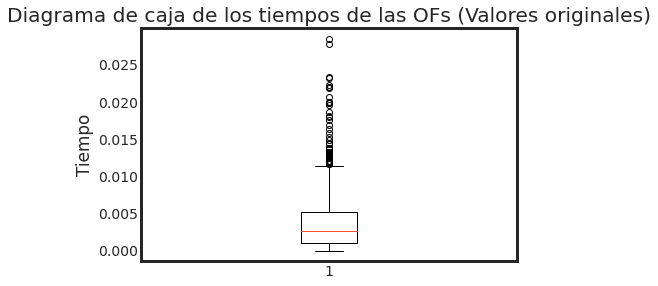

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

# Carga el dataframe
data = X_encoded_scaled.copy()

# Visualización del histograma de los valores invertidos
plt.hist(data['time_of'], bins=10)
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')
plt.title('Distribución de los tiempos de las OFs (Valores originales)')
plt.show()

# Estadísticas descriptivas de los valores invertidos
stats = data['time_of'].describe()
print(stats)

# Box plot de los valores invertidos
plt.boxplot(data['time_of'])
plt.ylabel('Tiempo')
plt.title('Diagrama de caja de los tiempos de las OFs (Valores originales)')
plt.show()

Posible mejora para este modelado, dividir el modelo en varios según el tiempo de duración de la OF

## CLASSIFIER MODEL

In [167]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Ruta completa del archivo CSV
ruta_archivo = 'data/processed_csv/df_model_final.csv'

# Leer el archivo CSV en un DataFrame
df_model_final = pd.read_csv(ruta_archivo)

# Corte rendimiento aceptable
performance_cutoff = 0.80

# Crear una instancia del MinMaxScaler y aplicar el escalado
scaler = MinMaxScaler()

df_model_final['achieve_performance'] = df_model_final['performance'].apply(lambda x: 1 if x >= performance_cutoff else 0)

df = df_model_final.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

# Realizar el escalado de las columnas 'y'
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled['grupo_qty'] = pd.cut(X_encoded_scaled['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled = pd.get_dummies(X_encoded_scaled, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled['time_of'] = X_encoded_scaled['good_qty_scaled'] * X_encoded_scaled['theorical_time_scaled']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_encoded_scaled, y_scaled, test_size=0.2, random_state=42)

In [168]:
# Crear el clasificador XGBoost
model = xgb.XGBClassifier(random_state=42)

# Entrenar el modelo
model.fit(X_train_scaled, y_train_scaled, verbose=True)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

result = X_test_scaled.copy()
result['prediction'] = y_pred
result['prediction_prob'] = y_pred_proba

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test_scaled, y_pred)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))

/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for examp

[20:07:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precisión del modelo: 81.18%


In [169]:
df_result_complete = pd.concat([result, df_model_final[df_model_final.index.isin(result.index)].loc[:, ~df_model_final.columns.isin(result.columns)]], axis=1)
df_result_complete.head()

,good_qty_scaled,theorical_time_scaled,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,grupo_qty_0,grupo_qty_1,grupo_qty_2,grupo_qty_3,grupo_qty_4,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,time_of,prediction,prediction_prob,order,bomb_type,line,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,registers_qty,operators_distinct_qty,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance
6,0.000333,0.884817,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000295,1.0,0.664931,5160396,1210,LINEA_1,2.0,0.0,2020-01-02 05:53:20.250,2020-01-02 08:59:16.247,11156,85.00,11155.997,185.933283,185.933283,4,1,2.187450,0.914306,3.098888,90% - 100%,3,AM,1,2020,1
8,0.029677,0.220314,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.006538,1.0,0.996123,5161187,8005,LINEA 6,90.0,0.0,2020-01-09 10:04:37.047,2020-01-13 07:30:49.483,49554,21.54,49553.920,825.898667,2273.027100,25,4,105.525864,0.852871,13.764978,80% - 90%,3,AM,1,2020,1
12,0.002334,0.738220,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0.001723,0.0,0.298117,5162165,56633-0890,LINEA_KIVU,8.0,0.0,2020-03-14 12:26:13.010,2020-03-18 14:09:47.310,38145,71.00,38145.143,635.752383,635.752383,19,2,8.954259,0.893430,10.595873,80% - 90%,5,AM,3,2020,1
14,0.009670,0.099058,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000958,1.0,0.967095,5162172,72560,LINEA_2,30.0,0.0,2020-05-08 09:15:14.813,2020-05-08 10:23:49.243,4115,

In [170]:
y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

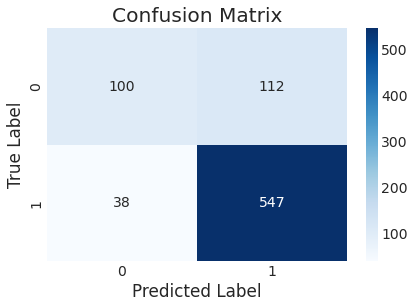

In [171]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Vamos a intentar tal y como tenemos actualmente el classificador si por algun optimizador podemos mejorar el modelo clasificador.

### MODEL CLASSIFIER - OPTIMIZATION HYPERPARAMS WITH OPTUNA

In [172]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Ruta completa del archivo CSV
ruta_archivo = 'data/processed_csv/df_model_final.csv'

# Leer el archivo CSV en un DataFrame
df_model_final = pd.read_csv(ruta_archivo)

# Corte rendimiento aceptable
performance_cutoff = 0.80

# Crear una instancia del MinMaxScaler y aplicar el escalado
scaler = MinMaxScaler()

df_model_final['achieve_performance'] = df_model_final['performance'].apply(lambda x: 1 if x >= performance_cutoff else 0)

df = df_model_final.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

# Realizar el escalado de las columnas 'y'
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled['grupo_qty'] = pd.cut(X_encoded_scaled['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled = pd.get_dummies(X_encoded_scaled, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled['time_of'] = X_encoded_scaled['good_qty_scaled'] * X_encoded_scaled['theorical_time_scaled']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_encoded_scaled, y_scaled, test_size=0.2, random_state=42)

Entrenando el modelo con todo el historico y un 80% de train y un 20% de test. He llegado a obtener un 82,43%.

Mejores hiperparámetros encontrados:
- max_depth: 3
- learning_rate: 0.3620591464749646
- n_estimators: 165
- min_child_weight: 5
- gamma: 0.18153092054929534
- subsample: 0.9605251319511919
- colsample_bytree: 0.1727481447514529
- reg_alpha: 0.6312990421100635
- reg_lambda: 0.21685117069036625

Vamos a separara los datos.Vamos a entrenar con todo el historico menos los datos del 2023 para guardarlos para hacer pruebas de validación y comprobar si tenemos un buen resultado

In [159]:
import pandas as pd
import xgboost as xgb
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Ruta completa del archivo CSV
ruta_archivo = 'data/processed_csv/df_model_final.csv'

# Leer el archivo CSV en un DataFrame
df_model_final = pd.read_csv(ruta_archivo)

# Corte rendimiento aceptable
performance_cutoff = 0.80

# Crear una instancia del MinMaxScaler y aplicar el escalado
scaler = MinMaxScaler()

df_model_final['achieve_performance'] = df_model_final['performance'].apply(lambda x: 1 if x >= performance_cutoff else 0)

# Obtener DataFrame de 2023 y DataFrame sin datos de 2023
df_model_final_2023 = df_model_final[df_model_final['year'] == 2023].copy()
df_model_final_2023.reset_index(inplace=True, drop=True)
df_model_final_not_2023 = df_model_final[df_model_final['year'] != 2023].copy()
df_model_final_not_2023.reset_index(inplace=True, drop=True)

df = df_model_final_not_2023.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

# Entrenar y transformar el scaler
scaler = MinMaxScaler().fit(X_encoded[['good_qty', 'theorical_time']])

# Guardar el scaler en un archivo
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

# Realizar el escalado de las columnas 'y'
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled['grupo_qty'] = pd.cut(X_encoded_scaled['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled = pd.get_dummies(X_encoded_scaled, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled['time_of'] = X_encoded_scaled['good_qty_scaled'] * X_encoded_scaled['theorical_time_scaled']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_encoded_scaled, y_scaled, test_size=0.2, random_state=42)

In [174]:
'''
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Definir la función objetivo para la optimización de Optuna
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'seed': 42,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    model = xgb.XGBClassifier(**params)
    model.fit(X_train_scaled, y_train_scaled)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluate predictions
    accuracy = accuracy_score(y_test_scaled, y_pred)
    return accuracy

# Crear el estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10000)

# Obtener los mejores hiperparámetros encontrados
best_params = study.best_params
'''

"\nimport optuna\nimport xgboost as xgb\nfrom sklearn.metrics import mean_squared_error\nfrom sklearn.model_selection import train_test_split\n\n# Definir la función objetivo para la optimización de Optuna\ndef objective(trial):\n    params = {\n        'max_depth': trial.suggest_int('max_depth', 1, 9),\n        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),\n        'n_estimators': trial.suggest_int('n_estimators', 50, 500),\n        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),\n        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),\n        'subsample': trial.suggest_float('subsample', 0.01, 1.0),\n        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),\n        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),\n        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),\n        'seed': 42,\n        'eval_metric': 'mlogloss',\n        'use_label_encoder': False\n    }\n\n    # Fit the model\n    model

- max_depth: 2
- learning_rate: 0.6710242790856933
- n_estimators: 491
- min_child_weight: 1
- gamma: 0.7146041724107204
- subsample: 0.9655797187832524
- colsample_bytree: 0.04041032024170345
- reg_alpha: 0.1059902187148698
- reg_lambda: 0.11869733033963767

Parece que este ensayo tiene el valor de evaluación más alto entre todos los ensayos realizados hasta ahora, como se indica en "Best is trial 6252 with value: 0.8316062176165803".

In [160]:
# Crear el clasificador XGBoost con los mejores hiperparámetros
model = xgb.XGBClassifier(
    max_depth= 2,
    learning_rate= 0.6710242790856933,
    n_estimators= 491,
    min_child_weight= 1,
    gamma= 0.7146041724107204,
    subsample= 0.9655797187832524,
    colsample_bytree= 0.04041032024170345,
    reg_alpha= 0.1059902187148698,
    reg_lambda= 0.11869733033963767,
    random_state= 42,
    eval_metric= 'mlogloss',
    use_label_encoder= False
)

# Entrenar el modelo
model.fit(X_train_scaled, y_train_scaled, verbose=True)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

result = X_test_scaled.copy()
result['prediction'] = y_pred
result['prediction_prob'] = y_pred_proba

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test_scaled, y_pred)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))

Precisión del modelo: 83.16%


In [163]:
import xgboost as xgb

print(xgb.__version__)

1.5.1


In [161]:
import pickle

# Ruta de archivo para guardar el modelo en formato pickle
model_pickle_path = 'modelo_xgboost_2.pickle'

# Guardar el modelo en formato pickle
with open(model_pickle_path, 'wb') as file:
    pickle.dump(loaded_booster, file)

XGBoostError: [22:46:08] /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:602: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?
Stack trace:
  [bt] (0) /home/pau-mila/miniconda3/envs/uic/lib/libxgboost.so(+0x1cf6eb) [0x7fac465cf6eb]
  [bt] (1) /home/pau-mila/miniconda3/envs/uic/lib/libxgboost.so(+0x1d930b) [0x7fac465d930b]
  [bt] (2) /home/pau-mila/miniconda3/envs/uic/lib/libxgboost.so(+0x1e8742) [0x7fac465e8742]
  [bt] (3) /home/pau-mila/miniconda3/envs/uic/lib/libxgboost.so(XGBoosterSerializeToBuffer+0x6b) [0x7fac464b56eb]
  [bt] (4) /home/pau-mila/miniconda3/envs/uic/lib/python3.7/lib-dynload/../../libffi.so.8(+0xa052) [0x7fac77d1c052]
  [bt] (5) /home/pau-mila/miniconda3/envs/uic/lib/python3.7/lib-dynload/../../libffi.so.8(+0x88cd) [0x7fac77d1a8cd]
  [bt] (6) /home/pau-mila/miniconda3/envs/uic/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(_ctypes_callproc+0x2f7) [0x7fac76b45287]
  [bt] (7) /home/pau-mila/miniconda3/envs/uic/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(+0xec59) [0x7fac76b44c59]
  [bt] (8) /home/pau-mila/miniconda3/envs/uic/bin/python(_PyObject_FastCallKeywords+0x430) [0x4c2b60]



In [157]:
import json

# Obtener el booster
booster = model.get_booster()

# Ruta de archivo para guardar el modelo
model_path = 'modelo_xgboost.json'

# Convertir el booster a diccionario
model_dict = booster.get_dump(dump_format='json')

# Guardar el modelo en formato JSON
with open(model_path, 'w') as file:
    json.dump(model_dict, file)

In [138]:
# Obtener el booster
booster = model.get_booster()

# Ruta de archivo para guardar el modelo
model_path = 'modelo_xgboost.bin'

# Guardar el modelo
booster.save_model(model_path)

In [27]:
import pickle

# Guardar el modelo en un archivo pickle
with open('modelo_xgboost.pickle', 'wb') as f:
    pickle.dump(model, f)

In [176]:
from sklearn.metrics import precision_score, recall_score

# Redondea las predicciones a las clases correspondientes (opcional)
y_pred_rounded = [round(pred) for pred in y_pred]

# Calcula la precisión
precision = precision_score(y_test_scaled, y_pred_rounded)

# Calcula el recall
recall = recall_score(y_test_scaled, y_pred_rounded)

# Imprime los resultados
print("Precisión:", precision)
print("Recall:", recall)

Precisión: 0.848966613672496
Recall: 0.9384885764499121


In [177]:
from sklearn.metrics import precision_score, recall_score

# Calcular la precisión
precision = precision_score(y_test_scaled, y_pred)
print("Precisión del modelo: %.2f%%" % (precision * 100.0))

# Calcular el recall
recall = recall_score(y_test_scaled, y_pred)
print("Recall del modelo: %.2f%%" % (recall * 100.0))

Precisión del modelo: 84.90%
Recall del modelo: 93.85%


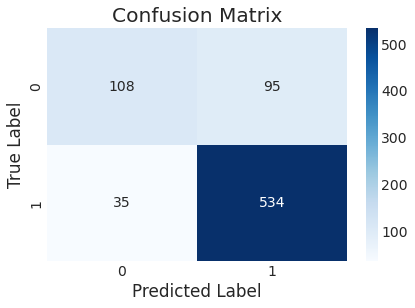

In [178]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df_result_complete = pd.concat([result, df_model_final_not_2023[df_model_final_not_2023.index.isin(result.index)].loc[:, ~df_model_final_not_2023.columns.isin(result.columns)]], axis=1)

y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

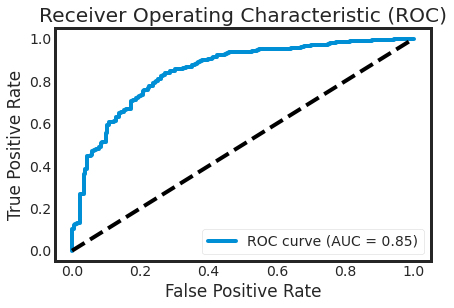

In [179]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Calcular la tasa de falsos positivos, la tasa de verdaderos positivos y los umbrales
fpr, tpr, thresholds = roc_curve(y_test_scaled, y_pred_proba)

# Calcular el área bajo la curva ROC
auc = roc_auc_score(y_test_scaled, y_pred_proba)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()

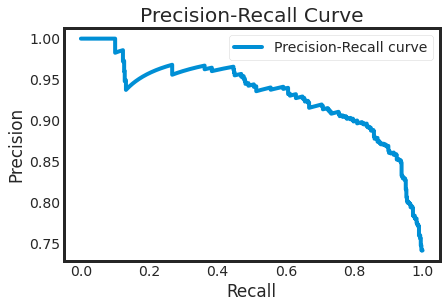

In [180]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calcular la precisión y la exhaustividad
precision, recall, _ = precision_recall_curve(y_test_scaled, y_pred_proba)

# Graficar la curva de Precisión-Recall
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Vamos a validar ahora con los datos que son del 2023 que el modelo ni ha conocido.

In [181]:
df = df_model_final_2023.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X_2023 = df[FEATURES]
y_2023 = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded_2023 = pd.get_dummies(X_2023)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled_2023 = pd.DataFrame(scaler.fit_transform(X_encoded_2023[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled_2023 = pd.concat([df_scaled_2023, X_encoded_2023], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled_2023 = X_encoded_scaled_2023.drop(columns=['good_qty', 'theorical_time'])

# Realizar el escalado de las columnas 'y'
y_scaled_2023 = scaler.fit_transform(y_2023.values.reshape(-1, 1))

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled_2023['grupo_qty'] = pd.cut(X_encoded_scaled_2023['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled_2023 = pd.get_dummies(X_encoded_scaled_2023, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled_2023['time_of'] = X_encoded_scaled_2023['good_qty_scaled'] * X_encoded_scaled_2023['theorical_time_scaled']

In [182]:
# Agregamos las columnas que no se habian creado debido al no disponer de esos datos en el 2023
# Insertar la nueva columna con todos los valores en 0 en la posición especificada
X_encoded_scaled_2023.insert(114, 'grupo_qty_3', 0)
X_encoded_scaled_2023.insert(121, 'weekday_5', 0)
X_encoded_scaled_2023.insert(122, 'weekday_6', 0)
X_encoded_scaled_2023.insert(125, 'month_3', 0)
X_encoded_scaled_2023.insert(126, 'month_4', 0)
X_encoded_scaled_2023.insert(127, 'month_5', 0)
X_encoded_scaled_2023.insert(128, 'month_6', 0)
X_encoded_scaled_2023.insert(129, 'month_7', 0)
X_encoded_scaled_2023.insert(130, 'month_8', 0)
X_encoded_scaled_2023.insert(131, 'month_9', 0)
X_encoded_scaled_2023.insert(132, 'month_10', 0)
X_encoded_scaled_2023.insert(133, 'month_11', 0)
X_encoded_scaled_2023.insert(134, 'month_12', 0)

In [183]:
# Realizar predicciones en el conjunto de prueba
y_pred_2023 = model.predict(X_encoded_scaled_2023)
y_pred_proba_2023 = model.predict_proba(X_encoded_scaled_2023)[:, 1]

result = X_encoded_scaled_2023.copy()
result['prediction'] = y_pred_2023
result['prediction_prob'] = y_pred_proba_2023

# Calcular la precisión del modelo
accuracy = accuracy_score(y_scaled_2023, y_pred_2023)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))

Precisión del modelo: 85.25%


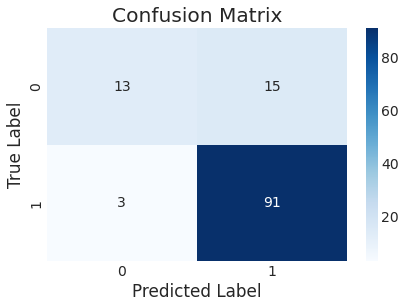

In [184]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df_result_complete = pd.concat([result, df_model_final_2023[df_model_final_2023.index.isin(result.index)].loc[:, ~df_model_final_2023.columns.isin(result.columns)]], axis=1)

y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

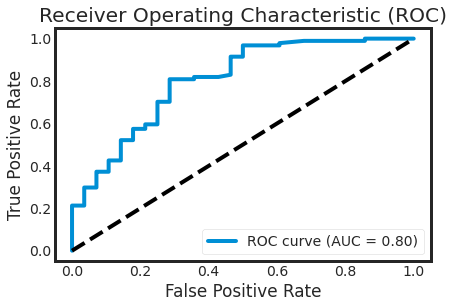

In [185]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Calcular la tasa de falsos positivos, la tasa de verdaderos positivos y los umbrales
fpr, tpr, thresholds = roc_curve(y_scaled_2023, y_pred_proba_2023)

# Calcular el área bajo la curva ROC
auc = roc_auc_score(y_scaled_2023, y_pred_proba_2023)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()

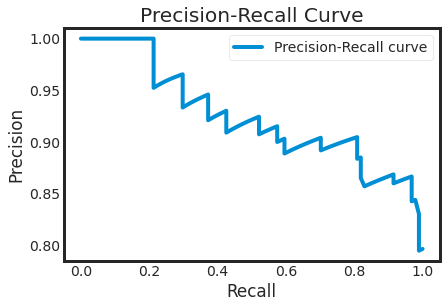

In [186]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calcular la precisión y la exhaustividad
precision, recall, _ = precision_recall_curve(y_scaled_2023, y_pred_proba_2023)

# Graficar la curva de Precisión-Recall
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Con los datos de validación, que nos habiamos guardado para validar el modelo.Observamos que tiene un buen comportamiento,dando un accuracy un poco mejor que el de entreno.

Vamos a probar otros dos modelos para comparar resultados.

### LightGBM

In [187]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Ruta completa del archivo CSV
ruta_archivo = 'data/processed_csv/df_model_final.csv'

# Leer el archivo CSV en un DataFrame
df_model_final = pd.read_csv(ruta_archivo)

# Corte rendimiento aceptable
performance_cutoff = 0.80

# Crear una instancia del MinMaxScaler y aplicar el escalado
scaler = MinMaxScaler()

df_model_final['achieve_performance'] = df_model_final['performance'].apply(lambda x: 1 if x >= performance_cutoff else 0)

# Obtener DataFrame de 2023 y DataFrame sin datos de 2023
df_model_final_2023 = df_model_final[df_model_final['year'] == 2023].copy()
df_model_final_2023.reset_index(inplace=True, drop=True)
df_model_final_not_2023 = df_model_final[df_model_final['year'] != 2023].copy()
df_model_final_not_2023.reset_index(inplace=True, drop=True)

df = df_model_final_not_2023.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

# Realizar el escalado de las columnas 'y'
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled['grupo_qty'] = pd.cut(X_encoded_scaled['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled = pd.get_dummies(X_encoded_scaled, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled['time_of'] = X_encoded_scaled['good_qty_scaled'] * X_encoded_scaled['theorical_time_scaled']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_encoded_scaled, y_scaled, test_size=0.2, random_state=42)

In [197]:
df_model_final

,order,bomb_type,line,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,registers_qty,operators_distinct_qty,theorical_qty,performance,time_diff_hours_calculated,performance_category,weekday,turn,month,year,achieve_performance,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994
0,5157110,01226-0890,LINEA_1,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,8,1,2.458296,0.813572,3.506349,80% - 90%,0,AM,1,2020,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5158184,11509INT,LINEA 6,12.0,0.0,2020-01-18 11:48:44.873,2020-01-18 12:46:26.833,3462,19.50,3461.960,57.699333,230.797333,2,4,11.835761,1.013877,0.961656,100% - 110%,5,AM,1,2020,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5158571,11509INT,LINEA 6,48.0,0.0,2020-02-03 11:29:08.710,2020-02-04 09:29:27.740,22323,19.50,22323.243,372.054050,1114.680950,7,3,57.163126,0.839702,6.200901,80% - 90%,0,AM,2,2020,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5159132,65566,LINEA_3,177.0,0.0,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,55912,6.87,55912.126,931.868767,1756.166533,20,2,255.628316,0.692412,15.531146,60% - 70%,3,AM,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5159134,65567,LINEA_2,270.0,0.0,2020-01-02 12:28:00.403,2020-01-08 06:20:32.553,36783,6.40,36783.083,613.051383,2446.176833,25,4,382.215130,0.706408,10.217523,70% - 80%,3,AM,1,2020,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [200]:
# Asume que df es tu DataFrame y 'operator' es el prefijo que estás buscando.
n_columnas_con_prefijo = len([col for col in df_model_final.columns if col.startswith('operator')])

print(n_columnas_con_prefijo)


103


In [199]:
numero_distintos = df_model_final['line'].nunique()
print(numero_distintos)


7


In [188]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import numpy as np

# Ponemos que porcentage aceptamos como probable que sea 1
performance_cutoff_lgb = 0.5

# Convertir y_train_scaled a un array unidimensional de NumPy
y_train_array = np.array(y_train_scaled).flatten()

# Crear el dataset de entrenamiento LightGBM
train_data_lgb = lgb.Dataset(X_train_scaled, label=y_train_array)

# Definir los parámetros del modelo LightGBM
params_lgb = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'seed': 42
}

# Entrenar el modelo LightGBM
model_lgb = lgb.train(params_lgb, train_data_lgb, num_boost_round=100)

# Realizar predicciones en el conjunto de prueba
y_pred_lgb = model_lgb.predict(X_test_scaled)
y_pred_lgb_binary = [1 if y >= performance_cutoff_lgb else 0 for y in y_pred_lgb]

result = X_test_scaled.copy()
result['prediction'] = y_pred_lgb_binary
result['prediction_prob'] = y_pred_lgb

# Calcular el accuracy del modelo LightGBM
accuracy_lgb = accuracy_score(y_test_scaled, y_pred_lgb_binary)
print("Accuracy del modelo LightGBM: {:.2f}%".format(accuracy_lgb * 100))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008496 seconds.
You can set `force_col_wise=true` to remove the overhead.
Accuracy del modelo LightGBM: 79.53%


In [189]:
from sklearn.metrics import precision_score, recall_score

# Redondea las predicciones a las clases correspondientes (opcional)
y_pred_rounded = [round(pred) for pred in y_pred_lgb]

# Calcula la precisión
precision = precision_score(y_test_scaled, y_pred_rounded)

# Calcula el recall
recall = recall_score(y_test_scaled, y_pred_rounded)

# Imprime los resultados
print("Precisión:", precision)
print("Recall:", recall)

Precisión: 0.8267090620031796
Recall: 0.9138840070298769


In [191]:
from sklearn.metrics import precision_score, recall_score

# Calcular la precisión
precision = precision_score(y_test_scaled, y_pred_lgb_binary)
print("Precisión del modelo: %.2f%%" % (precision * 100.0))

# Calcular el recall
recall = recall_score(y_test_scaled, y_pred_lgb_binary)
print("Recall del modelo: %.2f%%" % (recall * 100.0))

Precisión del modelo: 82.67%
Recall del modelo: 91.39%


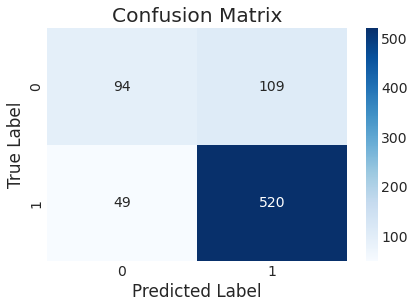

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df_result_complete = pd.concat([result, df_model_final_not_2023[df_model_final_not_2023.index.isin(result.index)].loc[:, ~df_model_final_not_2023.columns.isin(result.columns)]], axis=1)

y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Vamos a realizar la validación con los datos del 2023

In [ ]:
df = df_model_final_2023.copy()

TARGET = 'achieve_performance'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year', 'total_operators_minutes'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X_2023 = df[FEATURES]
y_2023 = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded_2023 = pd.get_dummies(X_2023)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled_2023 = pd.DataFrame(scaler.fit_transform(X_encoded_2023[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled_2023 = pd.concat([df_scaled_2023, X_encoded_2023], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled_2023 = X_encoded_scaled_2023.drop(columns=['good_qty', 'theorical_time'])

# Realizar el escalado de las columnas 'y'
y_scaled_2023 = scaler.fit_transform(y_2023.values.reshape(-1, 1))

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled_2023['grupo_qty'] = pd.cut(X_encoded_scaled_2023['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled_2023 = pd.get_dummies(X_encoded_scaled_2023, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled_2023['time_of'] = X_encoded_scaled_2023['good_qty_scaled'] * X_encoded_scaled_2023['theorical_time_scaled']

In [ ]:
# Agregamos las columnas que no se habian creado debido al no disponer de esos datos en el 2023
# Insertar la nueva columna con todos los valores en 0 en la posición especificada
X_encoded_scaled_2023.insert(114, 'grupo_qty_3', 0)
X_encoded_scaled_2023.insert(121, 'weekday_5', 0)
X_encoded_scaled_2023.insert(122, 'weekday_6', 0)
X_encoded_scaled_2023.insert(125, 'month_3', 0)
X_encoded_scaled_2023.insert(126, 'month_4', 0)
X_encoded_scaled_2023.insert(127, 'month_5', 0)
X_encoded_scaled_2023.insert(128, 'month_6', 0)
X_encoded_scaled_2023.insert(129, 'month_7', 0)
X_encoded_scaled_2023.insert(130, 'month_8', 0)
X_encoded_scaled_2023.insert(131, 'month_9', 0)
X_encoded_scaled_2023.insert(132, 'month_10', 0)
X_encoded_scaled_2023.insert(133, 'month_11', 0)
X_encoded_scaled_2023.insert(134, 'month_12', 0)

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred_lgb_2023 = model_lgb.predict(X_encoded_scaled_2023)
y_pred_lgb_binary_2023 = [1 if y >= performance_cutoff_lgb else 0 for y in y_pred_lgb_2023]

result = X_encoded_scaled_2023.copy()
result['prediction'] = y_pred_lgb_binary_2023
result['prediction_prob'] = y_pred_lgb_2023

# Calcular el accuracy del modelo LightGBM
accuracy_lgb = accuracy_score(y_scaled_2023, y_pred_lgb_binary_2023)
print("Accuracy del modelo LightGBM: {:.2f}%".format(accuracy_lgb * 100))

Accuracy del modelo LightGBM: 78.69%


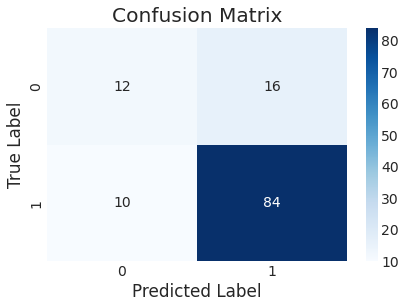

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df_result_complete = pd.concat([result, df_model_final_2023[df_model_final_2023.index.isin(result.index)].loc[:, ~df_model_final_2023.columns.isin(result.columns)]], axis=1)

y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Aplicamos el OPTUNA para obtener mejores parametros.

In [ ]:
# Crear el dataset de entrenamiento LightGBM
# Convertir y_train_scaled a un array unidimensional de NumPy
y_train_array = np.array(y_train_scaled).flatten()

# Crear el dataset de entrenamiento LightGBM
train_data_lgb = lgb.Dataset(X_train_scaled, label=y_train_array)

# Ponemos que porcentage aceptamos como probable que sea 1
performance_cutoff_lgb = 0.5



In [ ]:
'''
import lightgbm as lgb
import optuna
import warnings
from sklearn.metrics import accuracy_score

def objective(trial):

    # Definir los hiperparámetros a optimizar
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'verbose': 0,
        'seed': 42
    }

    # Entrenar el modelo LightGBM
    model_lgb = lgb.train(params_lgb, train_data_lgb, num_boost_round=100)

    # Realizar predicciones en el conjunto de prueba
    y_pred_lgb = model_lgb.predict(X_test_scaled)
    y_pred_lgb_binary = [1 if y >= performance_cutoff_lgb else 0 for y in y_pred_lgb]

    result = X_test_scaled.copy()
    result['prediction'] = y_pred_lgb_binary
    result['prediction_prob'] = y_pred_lgb

    return accuracy

# Crear el estudio Optuna y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5000)

# Obtener los mejores hiperparámetros
best_params = study.best_params

'''


"\nimport lightgbm as lgb\nimport optuna\nimport warnings\nfrom sklearn.metrics import accuracy_score\n\ndef objective(trial):\n\n    # Definir los hiperparámetros a optimizar\n    params = {\n        'objective': 'binary',\n        'metric': 'binary_logloss',\n        'boosting_type': 'gbdt',\n        'num_leaves': trial.suggest_int('num_leaves', 2, 50),\n        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),\n        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),\n        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),\n        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),\n        'verbose': 0,\n        'seed': 42\n    }\n\n    # Entrenar el modelo LightGBM\n    model_lgb = lgb.train(params_lgb, train_data_lgb, num_boost_round=100)\n\n    # Realizar predicciones en el conjunto de prueba\n    y_pred_lgb = model_lgb.predict(X_test_scaled)\n    y_pred_lgb_binary = [1 if y >= performance_cutoff_lgb e

In [ ]:
# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'max_depth': 7, 'learning_rate': 0.04215891448546176, 'n_estimators': 802, 'min_child_weight': 2, 'gamma': 0.010299087705971835, 'subsample': 0.7665097955177043, 'colsample_bytree': 0.9320282195461901, 'reg_alpha': 0.5086408853746989, 'reg_lambda': 0.429196612685647, 'random_state': 42}


Mejores hiperparámetros: 
{
    'num_leaves': 3,
    'learning_rate': 0.0017635427401370975,
    'feature_fraction': 0.4144730139275059,
    'bagging_fraction': 0.6912746534202228,
    'bagging_freq': 6
}

### ModeloLight GBM con los mejores hyperparametros

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import numpy as np

# Ponemos que porcentage aceptamos como probable que sea 1
performance_cutoff_lgb = 0.5

# Convertir y_train_scaled a un array unidimensional de NumPy
y_train_array = np.array(y_train_scaled).flatten()

# Crear el dataset de entrenamiento LightGBM
train_data_lgb = lgb.Dataset(X_train_scaled, label=y_train_array)

# Definir los parámetros del modelo LightGBM
params_lgb = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 3,
    'learning_rate': 0.0017635427401370975,
    'feature_fraction': 0.4144730139275059,
    'bagging_fraction': 0.6912746534202228,
    'bagging_freq': 6,
    'verbose': 0,
    'seed': 42
}

# Entrenar el modelo LightGBM
model_lgb = lgb.train(params_lgb, train_data_lgb, num_boost_round=100)

# Realizar predicciones en el conjunto de prueba
y_pred_lgb = model_lgb.predict(X_test_scaled)
y_pred_lgb_binary = [1 if y >= performance_cutoff_lgb else 0 for y in y_pred_lgb]

result = X_test_scaled.copy()
result['prediction'] = y_pred_lgb_binary
result['prediction_prob'] = y_pred_lgb

# Calcular el accuracy del modelo LightGBM
accuracy_lgb = accuracy_score(y_test_scaled, y_pred_lgb_binary)
print("Accuracy del modelo LightGBM: {:.2f}%".format(accuracy_lgb * 100))

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Accuracy del modelo LightGBM: 73.70%


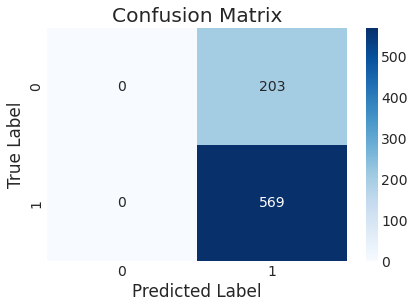

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df_result_complete = pd.concat([result, df_model_final_not_2023[df_model_final_not_2023.index.isin(result.index)].loc[:, ~df_model_final_not_2023.columns.isin(result.columns)]], axis=1)

y_true = df_result_complete['achieve_performance']
y_pred = df_result_complete['prediction']

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear el mapa de calor de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Optimización XGBOOST Classifier sin escalar los datos

In [23]:
# Ruta completa del archivo CSV
ruta_archivo = 'data/processed_csv/df_model_final.csv'

# Leer el archivo CSV en un DataFrame
df_model_final = pd.read_csv(ruta_archivo)

In [55]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Ruta completa del archivo CSV
ruta_archivo = 'data/processed_csv/df_model_final.csv'

# Leer el archivo CSV en un DataFrame
df_model_final = pd.read_csv(ruta_archivo)

# Crear una instancia del MinMaxScaler y aplicar el escalado
scaler = MinMaxScaler()

df = df_model_final.copy()

TARGET = 'total_operators_minutes'
exclude_columns = ['order', 'bomb_type', 'bad_qty', 'start_date', 'end_date', 'theorical_qty', 'theorical_diff',
                   'time_diff_seconds_calculated', 'time_diff_minutes_calculated', 'performance',
                   'time_diff_hours_calculated', 'achieve_performance', 'performance_category', 'registers_qty', 'operators_distinct_qty', 'turn', 'year'] + [TARGET]
FEATURES = [col for col in df.columns if col not in exclude_columns]

# Dividir los datos en características (features) y variable objetivo (target)
X = df[FEATURES]
y = df[TARGET]

# Convertimos las variable dummys en columnas con 0 o 1
X_encoded = pd.get_dummies(X)

# Realizar el escalado de las columnas 'good_qty' y 'theorical_time'
df_scaled = pd.DataFrame(scaler.fit_transform(X_encoded[['good_qty', 'theorical_time']]), columns=['good_qty_scaled', 'theorical_time_scaled'])
# Combinar el dataframe original con las columnas escaladas
X_encoded_scaled = pd.concat([df_scaled, X_encoded], axis=1)
# Eliminar las columnas 'good_qty' y 'theorical_time' del dataframe
X_encoded_scaled = X_encoded_scaled.drop(columns=['good_qty', 'theorical_time'])

# Realizar el escalado de las columnas 'y'
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Definir los límites de los grupos
grupo_1_limite = 0.2
grupo_2_limite = 0.4
grupo_3_limite = 0.6
grupo_4_limite = 0.8

# Crear la columna de grupos basada en 'good_qty_scaled'
X_encoded_scaled['grupo_qty'] = pd.cut(X_encoded_scaled['good_qty_scaled'], bins=[-float('inf'), grupo_1_limite, grupo_2_limite, grupo_3_limite, grupo_4_limite, float('inf')], labels=False, right=False)
# Aplicar el one-hot encoding a la columna de grupos
X_encoded_scaled = pd.get_dummies(X_encoded_scaled, columns=['grupo_qty','weekday','month'])

# Crear la nueva columna 'Multitime_ofplicacion' como el resultado de la multiplicación de 'good_qty_scaled' y 'theorical_time_scaled'
X_encoded_scaled['time_of'] = X_encoded_scaled['good_qty_scaled'] * X_encoded_scaled['theorical_time_scaled']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_encoded_scaled, y_scaled, test_size=0.2, random_state=42)

In [120]:
def parse_to_model(order,operators,line,plan_qty,theorical_time,production_date,available_operators,available_lines):

    model_path = '/home/pau-mila/UIC/05 - TFM - Fluidra/Fluidra-DS-Project/modelo_xgboost.pickle' 
    scaler_path = '/home/pau-mila/UIC/05 - TFM - Fluidra/Fluidra-DS-Project/scaler.pkl' 

    # Cargar el scaler desde un archivo
    with open(scaler_path, 'rb') as file:
        scaler = pickle.load(file)

    with open(model_path, 'rb') as file:
        model_xgboost = pickle.load(file)

    columns = ['good_qty_scaled', 'theorical_time_scaled']+['operator_' + str(i) for i in available_operators]+['line_' + str(i) for i in available_lines]+['grupo_qty_0', 'grupo_qty_1', 'grupo_qty_2', 'grupo_qty_3', 
               'grupo_qty_4', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_1', 'month_2', 'month_3', 'month_4', 
               'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'time_of']

    order_of = pd.DataFrame(np.zeros((1, len(columns))), columns=columns)

    scaled = scaler.transform([[plan_qty, theorical_time]])[0]
    
    order_of['good_qty_scaled'] = scaled[0]
    order_of['theorical_time_scaled'] = scaled[1]

    for operator in operators:
        order_of['operator_' + str(operator)] = 1

    order_of['line_' + line] = 1

    weekday = production_date.weekday()
    order_of['weekday_' + str(weekday)] = 1

    mes = production_date.month
    order_of['month_' + str(mes)] = 1

    # Definir los límites de los grupos
    grupo_1_limite = 0.2
    grupo_2_limite = 0.4
    grupo_3_limite = 0.6
    grupo_4_limite = 0.8

    order_of['grupo_qty_0'] = np.where(order_of['good_qty_scaled'] >= grupo_1_limite, 1, 0)
    order_of['grupo_qty_1'] = np.where((order_of['good_qty_scaled'] > grupo_1_limite) & (order_of['good_qty_scaled'] <= grupo_2_limite), 1, 0)
    order_of['grupo_qty_2'] = np.where((order_of['good_qty_scaled'] > grupo_2_limite) & (order_of['good_qty_scaled'] <= grupo_3_limite), 1, 0)
    order_of['grupo_qty_3'] = np.where((order_of['good_qty_scaled'] > grupo_3_limite) & (order_of['good_qty_scaled'] <= grupo_4_limite), 1, 0)
    order_of['grupo_qty_4'] = np.where(order_of['good_qty_scaled'] > grupo_4_limite, 1, 0)

    order_of['time_of'] = order_of['good_qty_scaled'] * order_of['theorical_time_scaled']

    y_pred = model_xgboost.predict(order_of)

    return y_pred


In [121]:
order = 5160396
operators = (50,642)
line = 'LINEA 4'
theorical_time = 85
plan_qty = 345
production_date = fecha_actual

available_operators = ['37', '50', '215', '287', '412', '504', '642', '643', '654', '657', '662', '918', '1007', '5004', '5015', '5020', '5025', '5030', '5033', '5036', '5069', '5096', '7009', '7028', '8007', '8093', '8164', '8177', '8230', '8250', '8372', '8615', '8676', '8721', '8733', '8752', '8820', '8821', '8822', '8824', '8830', '8833', '8857', '8860', '8866', '8867', '8871', '8894', '8901', '8945', '9102', '9104', '9105', '9108', '9109', '9110', '9114', '9120', '9122', '9141', '9142', '9147', '9166', '9188', '9199', '9227', '9230', '9235', '9253', '9254', '9265', '9266', '9279', '9280', '9289', '9317', '9318', '9324', '9327', '9348', '9349', '9351', '9352', '9360', '9374', '9378', '9379', '9380', '9388', '9391', '9395', '9396', '9403', '9421', '9422', '9436', '9443', '9445', '9508', '9511', '9992', '9994']
available_lines = ['LINEA 4', 'LINEA 6', 'LINEA_1', 'LINEA_2', 'LINEA_3', 'LINEA_7', 'LINEA_KIVU']

In [122]:
y = parse_to_model(order=order, operators=operators, line=line, plan_qty=plan_qty, theorical_time=theorical_time, production_date=production_date, available_operators=available_operators, available_lines=available_lines)

y

/home/pau-mila/miniconda3/envs/uic/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


array([1])

In [123]:
    model_path = '/home/pau-mila/UIC/05 - TFM - Fluidra/Fluidra-DS-Project/modelo_xgboost.pickle' 

    with open(model_path, 'rb') as file:
        model_xgboost = pickle.load(file)

In [139]:
model_path = '/home/pau-mila/UIC/05 - TFM - Fluidra/Fluidra-DS-Project/modelo_xgboost.bin' 

# Cargar el modelo
loaded_booster = xgb.Booster()
loaded_booster.load_model(model_path)

In [170]:
def parse_to_model_prueba(order,operators,line,plan_qty,theorical_time,production_date,available_operators,available_lines):

    scaler_path = '/home/pau-mila/UIC/05 - TFM - Fluidra/Fluidra-DS-Project/scaler.pkl' 

    # Cargar el scaler desde un archivo
    with open(scaler_path, 'rb') as file:
        scaler = pickle.load(file)


    columns = ['good_qty_scaled', 'theorical_time_scaled']+['operator_' + str(i) for i in available_operators]+['line_' + str(i) for i in available_lines]+['grupo_qty_0', 'grupo_qty_1', 'grupo_qty_2', 'grupo_qty_3', 
               'grupo_qty_4', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_1', 'month_2', 'month_3', 'month_4', 
               'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'time_of']

    order_of = pd.DataFrame(np.zeros((1, len(columns))), columns=columns)

    data = {
    'good_qty': [plan_qty],
    'theorical_time': [theorical_time]
    }

    df = pd.DataFrame(data)

    scaled = scaler.transform(df[['good_qty', 'theorical_time']])

    order_of['good_qty_scaled'] = scaled[:, 0]
    order_of['theorical_time_scaled'] = scaled[:, 1]


    for operator in operators:
        order_of['operator_' + str(operator)] = 1

    order_of['line_' + line] = 1

    weekday = production_date.weekday()
    order_of['weekday_' + str(weekday)] = 1

    mes = production_date.month
    order_of['month_' + str(mes)] = 1

    # Definir los límites de los grupos
    grupo_1_limite = 0.2
    grupo_2_limite = 0.4
    grupo_3_limite = 0.6
    grupo_4_limite = 0.8

    order_of['grupo_qty_0'] = np.where(order_of['good_qty_scaled'] <= grupo_1_limite, 1, 0)
    order_of['grupo_qty_1'] = np.where((order_of['good_qty_scaled'] > grupo_1_limite) & (order_of['good_qty_scaled'] <= grupo_2_limite), 1, 0)
    order_of['grupo_qty_2'] = np.where((order_of['good_qty_scaled'] > grupo_2_limite) & (order_of['good_qty_scaled'] <= grupo_3_limite), 1, 0)
    order_of['grupo_qty_3'] = np.where((order_of['good_qty_scaled'] > grupo_3_limite) & (order_of['good_qty_scaled'] <= grupo_4_limite), 1, 0)
    order_of['grupo_qty_4'] = np.where(order_of['good_qty_scaled'] > grupo_4_limite, 1, 0)

    order_of['time_of'] = order_of['good_qty_scaled'] * order_of['theorical_time_scaled']


    return order_of


In [171]:
from datetime import datetime

order = 5376213
operators = (9436,9443,9280)
line = 'LINEA_2'
theorical_time = 8.02
plan_qty = 100
production_date = datetime(2023,1,25)

available_operators = ['37', '50', '215', '287', '412', '504', '642', '643', '654', '657', '662', '918', '1007', '5004', '5015', '5020', '5025', '5030', '5033', '5036', '5069', '5096', '7009', '7028', '8007', '8093', '8164', '8177', '8230', '8250', '8372', '8615', '8676', '8721', '8733', '8752', '8820', '8821', '8822', '8824', '8830', '8833', '8857', '8860', '8866', '8867', '8871', '8894', '8901', '8945', '9102', '9104', '9105', '9108', '9109', '9110', '9114', '9120', '9122', '9141', '9142', '9147', '9166', '9188', '9199', '9227', '9230', '9235', '9253', '9254', '9265', '9266', '9279', '9280', '9289', '9317', '9318', '9324', '9327', '9348', '9349', '9351', '9352', '9360', '9374', '9378', '9379', '9380', '9388', '9391', '9395', '9396', '9403', '9421', '9422', '9436', '9443', '9445', '9508', '9511', '9992', '9994']
available_lines = ['LINEA 4', 'LINEA 6', 'LINEA_1', 'LINEA_2', 'LINEA_3', 'LINEA_7', 'LINEA_KIVU']

In [173]:
df = parse_to_model_prueba(order=order, operators=operators, line=line, plan_qty=plan_qty, theorical_time=theorical_time, production_date=production_date, available_operators=available_operators, available_lines=available_lines)

df

,good_qty_scaled,theorical_time_scaled,operator_37,operator_50,operator_215,operator_287,operator_412,operator_504,operator_642,operator_643,operator_654,operator_657,operator_662,operator_918,operator_1007,operator_5004,operator_5015,operator_5020,operator_5025,operator_5030,operator_5033,operator_5036,operator_5069,operator_5096,operator_7009,operator_7028,operator_8007,operator_8093,operator_8164,operator_8177,operator_8230,operator_8250,operator_8372,operator_8615,operator_8676,operator_8721,operator_8733,operator_8752,operator_8820,operator_8821,operator_8822,operator_8824,operator_8830,operator_8833,operator_8857,operator_8860,operator_8866,operator_8867,operator_8871,operator_8894,operator_8901,operator_8945,operator_9102,operator_9104,operator_9105,operator_9108,operator_9109,operator_9110,operator_9114,operator_9120,operator_9122,operator_9141,operator_9142,operator_9147,operator_9166,operator_9188,operator_9199,operator_9227,operator_9230,operator_9235,operator_9253,operator_9254,operator_9265,operator_9266,operator_9279,operator_9280,operator_9289,operator_9317,operator_9318,operator_9324,operator_9327,operator_9348,operator_9349,operator_9351,operator_9352,operator_9360,operator_9374,operator_9378,operator_9379,operator_9380,operator_9388,operator_9391,operator_9395,operator_9396,operator_9403,operator_9421,operator_9422,operator_9436,operator_9443,operator_9445,operator_9508,operator_9511,operator_9992,operator_9994,line_LINEA 4,line_LINEA 6,line_LINEA_1,line_LINEA_2,line_LINEA_3,line_LINEA_7,line_LINEA_KIVU,grupo_qty_0,grupo_qty_1,grupo_qty_2,grupo_qty_3,grupo_qty_4,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,time_of
0,0.033011,0.078743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002599
